<a href="https://colab.research.google.com/github/StefanoJP/digit_recognizer/blob/main/week2_exp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install library

In [ ]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Mounted at /content/drive


In [ ]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 3.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=ea80384abb9c8bdecfdcb6fbaa349a76fe7ef23c61e640af8c941588f17d96d7
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
 35% 5.00M/14.3M [00:00<00:00, 29.4MB/s]
100% 14.3M/14.3M [00:00<00:00, 56.2MB/s]


In [ ]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

import timm
warnings.filterwarnings('ignore')

     |████████████████████████████████| 117 kB 8.4 MB/s 
     |████████████████████████████████| 948 kB 17.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=81896275b63490c9c27a9dc5d7116e8574a3c49cae92553936ac9bbe6022d9f2
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Config


In [ ]:
class Config:
    Version = "exp3" # model save時のversion
    #MODEL_NAME = "resnet34" # モデル名
    MODEL_NAME = "resnet50" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名

    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        data_dir = '../input/digit-recognizer/' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer'
        data_dir = os.path.join(base_dir, 'data')
        pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    fold = 0
    num_workers = 0 #並列実行する数
    batch_size = 64 #バッチサイズ was 64 >100
    epochs =40 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 5 # 最大イテレーション数 was 10
    min_lr = 1e-6 # 学習率の最小値
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    class_num = 10
    N_FOLDS = 5
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [ ]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [ ]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [ ]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [ ]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']

        label = self.labels[idx] # 正解ラベル
        return image, label

In [ ]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [ ]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Model

In [ ]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# train & valid function

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ
        batch_size = labels.size(0) 
        y_preds = model(images) # 予測ラベル
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [ ]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [ ]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
else:
    train = pd.read_csv(f'{Config.data_dir}/train/train.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import plotly.express as px

target = train.label.value_counts()
# class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [ ]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [ ]:
# f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
# train["folds"] = -1
# train.loc[f0.index, "folds"] = 1
# train.loc[f1.index, "folds"] = 0

## StratifiedKFold


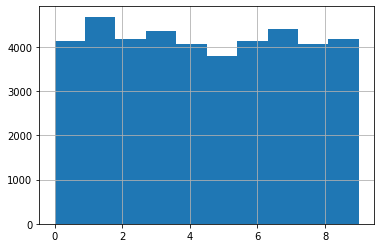

In [ ]:
train['bins'] = pd.cut(train['label'], bins=Config.class_num, labels=False)
train['bins'].hist()

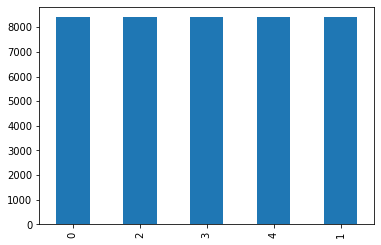

In [ ]:
from sklearn.model_selection import StratifiedKFold

train['fold'] = -1

strat_kfold = StratifiedKFold(n_splits=Config.N_FOLDS, random_state=Config.seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train.index, train['bins'])):
    train.iloc[train_index, -1] = i
    
train['fold'] = train['fold'].astype('int')

train.fold.value_counts().plot.bar()

In [ ]:
train[train['fold']==0].head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,bins,fold
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0
9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0


In [ ]:
train[train['fold']==0]['bins'].value_counts()

1    937
7    880
3    870
9    838
2    835
0    827
6    827
4    814
8    813
5    759
Name: bins, dtype: int64

In [ ]:
train[train['fold']==1]['bins'].value_counts()

1    937
7    880
3    870
9    837
2    836
6    827
0    826
4    815
8    813
5    759
Name: bins, dtype: int64

#### 平均と標準偏差を計算

In [ ]:
images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
norms = (np.mean(images[train.fold!=0] / 255), np.std(images[train.fold!=0] / 255)) # 平均と標準偏差を計算
print("平均と標準偏差: ", norms)

平均と標準偏差:  (0.13097058957511565, 0.30850036897768457)


#### 画像サイズの確認と数例を表示

height:  28
weight:  28


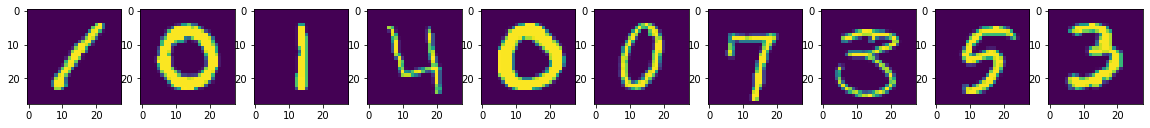

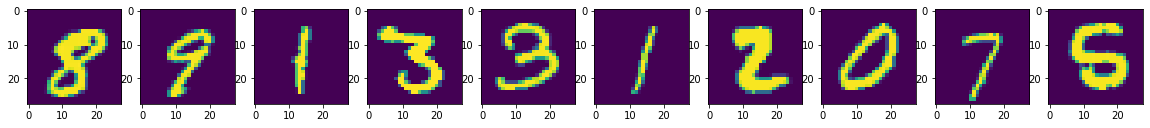

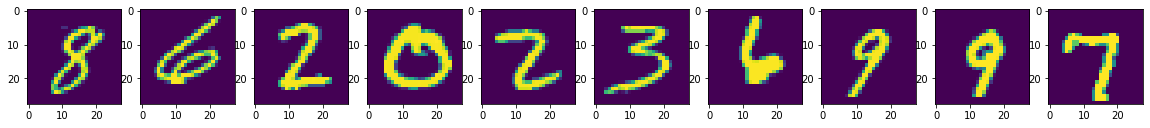

In [ ]:
print("height: ", images.shape[1])
print("weight: ", images.shape[2])

for n in range(3):
    fig, axes = plt.subplots(1, 10, figsize=(20, 30))
    [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

    plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [ ]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

### 最適化関数

In [ ]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)

### スケジューラ

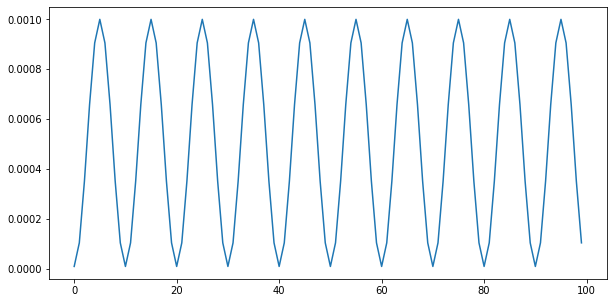

In [ ]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

# 学習

In [ ]:
def train_loop(train, fold, class_num=Config.class_num, norms=(0.5, 0.5)):
    
    print('='*20 +'Fold '+ f'{fold}' + '='*20)
    train_index = train[train['fold'] != fold].index # 学習用のindex
    valid_index = train[train['fold'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion = nn.CrossEntropyLoss() # loss function

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [ ]:
preds = [train_loop(train, fold=fold, class_num=Config.class_num, norms=norms) for fold in range(Config.N_FOLDS) ]

====================Fold 0====================
Epoch: [1][0/525] Data 0.232 (0.232) Elapsed 0m 0s (remain 7m 42s) Loss: 6.9503(6.9503) 
Epoch: [1][524/525] Data 0.128 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 2.0668(3.5146) 
EVAL: [0/132] Data 0.134 (0.134) Elapsed 0m 0s (remain 0m 31s) Loss: 2.1216(2.1216) 


Epoch 1 - avg_train_loss: 3.5146  avg_val_loss: 2.0747  time: 296s
Epoch 1 - Accuracy: 0.3644047619047619
Epoch 1 - Save Best Score: 0.3644 Model


EVAL: [131/132] Data 0.032 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 2.0785(2.0747) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [2][0/525] Data 0.153 (0.153) Elapsed 0m 0s (remain 4m 32s) Loss: 2.0720(2.0720) 
Epoch: [2][524/525] Data 0.139 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 1.5332(1.8458) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 32s) Loss: 1.7369(1.7369) 


Epoch 2 - avg_train_loss: 1.8458  avg_val_loss: 1.6594  time: 294s
Epoch 2 - Accuracy: 0.5454761904761904
Epoch 2 - Save Best Score: 0.5455 Model


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 1.6437(1.6594) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [3][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 24s) Loss: 1.6528(1.6528) 
Epoch: [3][524/525] Data 0.130 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 1.3053(1.4849) 
EVAL: [0/132] Data 0.148 (0.148) Elapsed 0m 0s (remain 0m 33s) Loss: 1.4175(1.4175) 


Epoch 3 - avg_train_loss: 1.4849  avg_val_loss: 1.3075  time: 294s
Epoch 3 - Accuracy: 0.6965476190476191
Epoch 3 - Save Best Score: 0.6965 Model


EVAL: [131/132] Data 0.032 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 1.3131(1.3075) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [4][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 24s) Loss: 1.3415(1.3415) 
Epoch: [4][524/525] Data 0.127 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 1.0316(1.1920) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 1.2300(1.2300) 


Epoch 4 - avg_train_loss: 1.1920  avg_val_loss: 1.1261  time: 294s
Epoch 4 - Accuracy: 0.7432142857142857
Epoch 4 - Save Best Score: 0.7432 Model


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 1.1214(1.1261) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [5][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 25s) Loss: 1.0889(1.0889) 
Epoch: [5][524/525] Data 0.134 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.8589(1.0036) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 1.0892(1.0892) 


Epoch 5 - avg_train_loss: 1.0036  avg_val_loss: 0.9771  time: 293s
Epoch 5 - Accuracy: 0.8052380952380952
Epoch 5 - Save Best Score: 0.8052 Model


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.9876(0.9771) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [6][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 24s) Loss: 0.9163(0.9163) 
Epoch: [6][524/525] Data 0.127 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.9195(0.9144) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 1.0235(1.0235) 


Epoch 6 - avg_train_loss: 0.9144  avg_val_loss: 0.8828  time: 293s
Epoch 6 - Accuracy: 0.8292857142857143
Epoch 6 - Save Best Score: 0.8293 Model


EVAL: [131/132] Data 0.033 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.9202(0.8828) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [7][0/525] Data 0.135 (0.135) Elapsed 0m 0s (remain 4m 24s) Loss: 0.8247(0.8247) 
Epoch: [7][524/525] Data 0.132 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.8657(0.8390) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.9150(0.9150) 


Epoch 7 - avg_train_loss: 0.8390  avg_val_loss: 0.7992  time: 293s
Epoch 7 - Accuracy: 0.8436904761904762
Epoch 7 - Save Best Score: 0.8437 Model


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.8435(0.7992) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [8][0/525] Data 0.153 (0.153) Elapsed 0m 0s (remain 4m 33s) Loss: 0.6824(0.6824) 
Epoch: [8][524/525] Data 0.131 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.6751(0.7017) 
EVAL: [0/132] Data 0.147 (0.147) Elapsed 0m 0s (remain 0m 33s) Loss: 0.7680(0.7680) 


Epoch 8 - avg_train_loss: 0.7017  avg_val_loss: 0.6143  time: 294s
Epoch 8 - Accuracy: 0.8852380952380953
Epoch 8 - Save Best Score: 0.8852 Model


EVAL: [131/132] Data 0.033 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.6934(0.6143) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [9][0/525] Data 0.149 (0.149) Elapsed 0m 0s (remain 4m 30s) Loss: 0.5835(0.5835) 
Epoch: [9][524/525] Data 0.125 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.4695(0.5046) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.5900(0.5900) 


Epoch 9 - avg_train_loss: 0.5046  avg_val_loss: 0.4501  time: 293s
Epoch 9 - Accuracy: 0.9182142857142858
Epoch 9 - Save Best Score: 0.9182 Model


EVAL: [131/132] Data 0.033 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.4688(0.4501) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [10][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 25s) Loss: 0.4261(0.4261) 
Epoch: [10][524/525] Data 0.131 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.4344(0.3339) 
EVAL: [0/132] Data 0.124 (0.124) Elapsed 0m 0s (remain 0m 30s) Loss: 0.6200(0.6200) 


Epoch 10 - avg_train_loss: 0.3339  avg_val_loss: 0.4689  time: 294s
Epoch 10 - Accuracy: 0.871547619047619


EVAL: [131/132] Data 0.033 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.6375(0.4689) 
Epoch: [11][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 24s) Loss: 0.2435(0.2435) 
Epoch: [11][524/525] Data 0.134 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.2035(0.2287) 
EVAL: [0/132] Data 0.131 (0.131) Elapsed 0m 0s (remain 0m 31s) Loss: 0.4187(0.4187) 


Epoch 11 - avg_train_loss: 0.2287  avg_val_loss: 0.3257  time: 293s
Epoch 11 - Accuracy: 0.9263095238095238
Epoch 11 - Save Best Score: 0.9263 Model


EVAL: [131/132] Data 0.032 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2756(0.3257) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [12][0/525] Data 0.147 (0.147) Elapsed 0m 0s (remain 4m 29s) Loss: 0.1617(0.1617) 
Epoch: [12][524/525] Data 0.132 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.1650(0.1700) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.8675(0.8675) 


Epoch 12 - avg_train_loss: 0.1700  avg_val_loss: 0.6279  time: 293s
Epoch 12 - Accuracy: 0.78


EVAL: [131/132] Data 0.033 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.7166(0.6279) 
Epoch: [13][0/525] Data 0.149 (0.149) Elapsed 0m 0s (remain 4m 32s) Loss: 0.1085(0.1085) 
Epoch: [13][524/525] Data 0.131 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.1278(0.1354) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 32s) Loss: 0.8784(0.8784) 


Epoch 13 - avg_train_loss: 0.1354  avg_val_loss: 0.6541  time: 293s
Epoch 13 - Accuracy: 0.7838095238095238


EVAL: [131/132] Data 0.031 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.6173(0.6541) 
Epoch: [14][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 24s) Loss: 0.1933(0.1933) 
Epoch: [14][524/525] Data 0.126 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.0684(0.1159) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.2123(0.2123) 


Epoch 14 - avg_train_loss: 0.1159  avg_val_loss: 0.1358  time: 293s
Epoch 14 - Accuracy: 0.9688095238095238
Epoch 14 - Save Best Score: 0.9688 Model


EVAL: [131/132] Data 0.032 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1347(0.1358) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [15][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 24s) Loss: 0.1474(0.1474) 
Epoch: [15][524/525] Data 0.132 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0871(0.1033) 
EVAL: [0/132] Data 0.129 (0.129) Elapsed 0m 0s (remain 0m 30s) Loss: 0.1894(0.1894) 


Epoch 15 - avg_train_loss: 0.1033  avg_val_loss: 0.1151  time: 294s
Epoch 15 - Accuracy: 0.9719047619047619
Epoch 15 - Save Best Score: 0.9719 Model


EVAL: [131/132] Data 0.032 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1097(0.1151) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [16][0/525] Data 0.134 (0.134) Elapsed 0m 0s (remain 4m 22s) Loss: 0.1283(0.1283) 
Epoch: [16][524/525] Data 0.127 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.1027(0.0980) 
EVAL: [0/132] Data 0.130 (0.130) Elapsed 0m 0s (remain 0m 31s) Loss: 0.2362(0.2362) 


Epoch 16 - avg_train_loss: 0.0980  avg_val_loss: 0.1514  time: 293s
Epoch 16 - Accuracy: 0.9628571428571429


EVAL: [131/132] Data 0.031 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1612(0.1514) 
Epoch: [17][0/525] Data 0.130 (0.130) Elapsed 0m 0s (remain 4m 21s) Loss: 0.1154(0.1154) 
Epoch: [17][524/525] Data 0.137 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.0821(0.0961) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1875(0.1875) 


Epoch 17 - avg_train_loss: 0.0961  avg_val_loss: 0.1224  time: 293s
Epoch 17 - Accuracy: 0.9675


EVAL: [131/132] Data 0.032 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0563(0.1224) 
Epoch: [18][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0963(0.0963) 
Epoch: [18][524/525] Data 0.134 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.0873(0.0921) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1499(0.1499) 


Epoch 18 - avg_train_loss: 0.0921  avg_val_loss: 0.1064  time: 293s
Epoch 18 - Accuracy: 0.9708333333333333


EVAL: [131/132] Data 0.032 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0709(0.1064) 
Epoch: [19][0/525] Data 0.146 (0.146) Elapsed 0m 0s (remain 4m 29s) Loss: 0.1159(0.1159) 
Epoch: [19][524/525] Data 0.134 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.0705(0.0890) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1570(0.1570) 


Epoch 19 - avg_train_loss: 0.0890  avg_val_loss: 0.1070  time: 294s
Epoch 19 - Accuracy: 0.9723809523809523
Epoch 19 - Save Best Score: 0.9724 Model


EVAL: [131/132] Data 0.034 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0526(0.1070) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [20][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 30s) Loss: 0.1006(0.1006) 
Epoch: [20][524/525] Data 0.132 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0974(0.0791) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 33s) Loss: 0.3493(0.3493) 


Epoch 20 - avg_train_loss: 0.0791  avg_val_loss: 0.2801  time: 294s
Epoch 20 - Accuracy: 0.9139285714285714


EVAL: [131/132] Data 0.030 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1414(0.2801) 
Epoch: [21][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0553(0.0553) 
Epoch: [21][524/525] Data 0.127 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0393(0.0668) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 31s) Loss: 0.2337(0.2337) 


Epoch 21 - avg_train_loss: 0.0668  avg_val_loss: 0.1605  time: 294s
Epoch 21 - Accuracy: 0.9519047619047619


EVAL: [131/132] Data 0.030 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1255(0.1605) 
Epoch: [22][0/525] Data 0.130 (0.130) Elapsed 0m 0s (remain 4m 21s) Loss: 0.0537(0.0537) 
Epoch: [22][524/525] Data 0.125 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0489(0.0572) 
EVAL: [0/132] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1312(0.1312) 


Epoch 22 - avg_train_loss: 0.0572  avg_val_loss: 0.0753  time: 294s
Epoch 22 - Accuracy: 0.9795238095238096
Epoch 22 - Save Best Score: 0.9795 Model


EVAL: [131/132] Data 0.031 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0248(0.0753) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [23][0/525] Data 0.145 (0.145) Elapsed 0m 0s (remain 4m 28s) Loss: 0.0823(0.0823) 
Epoch: [23][524/525] Data 0.133 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0328(0.0475) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 31s) Loss: 0.2177(0.2177) 


Epoch 23 - avg_train_loss: 0.0475  avg_val_loss: 0.1103  time: 295s
Epoch 23 - Accuracy: 0.9667857142857142


EVAL: [131/132] Data 0.030 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0232(0.1103) 
Epoch: [24][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0741(0.0741) 
Epoch: [24][524/525] Data 0.133 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0348(0.0388) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0896(0.0896) 


Epoch 24 - avg_train_loss: 0.0388  avg_val_loss: 0.0689  time: 294s
Epoch 24 - Accuracy: 0.9803571428571428
Epoch 24 - Save Best Score: 0.9804 Model


EVAL: [131/132] Data 0.033 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0183(0.0689) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [25][0/525] Data 0.135 (0.135) Elapsed 0m 0s (remain 4m 23s) Loss: 0.0758(0.0758) 
Epoch: [25][524/525] Data 0.136 (0.134) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0501(0.0336) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1040(0.1040) 


Epoch 25 - avg_train_loss: 0.0336  avg_val_loss: 0.0622  time: 295s
Epoch 25 - Accuracy: 0.9827380952380952
Epoch 25 - Save Best Score: 0.9827 Model


EVAL: [131/132] Data 0.035 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0134(0.0622) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [26][0/525] Data 0.135 (0.135) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0111(0.0111) 
Epoch: [26][524/525] Data 0.133 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0309(0.0325) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1046(0.1046) 


Epoch 26 - avg_train_loss: 0.0325  avg_val_loss: 0.0598  time: 294s
Epoch 26 - Accuracy: 0.9825


EVAL: [131/132] Data 0.032 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0117(0.0598) 
Epoch: [27][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0313(0.0313) 
Epoch: [27][524/525] Data 0.138 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0514(0.0313) 
EVAL: [0/132] Data 0.147 (0.147) Elapsed 0m 0s (remain 0m 33s) Loss: 0.1108(0.1108) 


Epoch 27 - avg_train_loss: 0.0313  avg_val_loss: 0.0607  time: 294s
Epoch 27 - Accuracy: 0.9822619047619048


EVAL: [131/132] Data 0.031 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0168(0.0607) 
Epoch: [28][0/525] Data 0.134 (0.134) Elapsed 0m 0s (remain 4m 23s) Loss: 0.0203(0.0203) 
Epoch: [28][524/525] Data 0.130 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0938(0.0326) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1342(0.1342) 


Epoch 28 - avg_train_loss: 0.0326  avg_val_loss: 0.0867  time: 294s
Epoch 28 - Accuracy: 0.9742857142857143


EVAL: [131/132] Data 0.032 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0284(0.0867) 
Epoch: [29][0/525] Data 0.132 (0.132) Elapsed 0m 0s (remain 4m 21s) Loss: 0.0245(0.0245) 
Epoch: [29][524/525] Data 0.130 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0237(0.0343) 
EVAL: [0/132] Data 0.151 (0.151) Elapsed 0m 0s (remain 0m 33s) Loss: 0.2106(0.2106) 


Epoch 29 - avg_train_loss: 0.0343  avg_val_loss: 0.1200  time: 294s
Epoch 29 - Accuracy: 0.9630952380952381


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0806(0.1200) 
Epoch: [30][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0975(0.0975) 
Epoch: [30][524/525] Data 0.132 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0420(0.0336) 
EVAL: [0/132] Data 0.153 (0.153) Elapsed 0m 0s (remain 0m 35s) Loss: 0.8014(0.8014) 


Epoch 30 - avg_train_loss: 0.0336  avg_val_loss: 0.5265  time: 294s
Epoch 30 - Accuracy: 0.8284523809523809


EVAL: [131/132] Data 0.037 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.4421(0.5265) 
Epoch: [31][0/525] Data 0.135 (0.135) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0338(0.0338) 
Epoch: [31][524/525] Data 0.129 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0326(0.0291) 
EVAL: [0/132] Data 0.135 (0.135) Elapsed 0m 0s (remain 0m 31s) Loss: 0.2635(0.2635) 


Epoch 31 - avg_train_loss: 0.0291  avg_val_loss: 0.2311  time: 294s
Epoch 31 - Accuracy: 0.9041666666666667


EVAL: [131/132] Data 0.030 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1184(0.2311) 
Epoch: [32][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0147(0.0147) 
Epoch: [32][524/525] Data 0.129 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0095(0.0243) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1005(0.1005) 


Epoch 32 - avg_train_loss: 0.0243  avg_val_loss: 0.0789  time: 294s
Epoch 32 - Accuracy: 0.9771428571428571


EVAL: [131/132] Data 0.031 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0132(0.0789) 
Epoch: [33][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0116(0.0116) 
Epoch: [33][524/525] Data 0.130 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0199(0.0184) 
EVAL: [0/132] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1160(0.1160) 


Epoch 33 - avg_train_loss: 0.0184  avg_val_loss: 0.0598  time: 294s
Epoch 33 - Accuracy: 0.9821428571428571


EVAL: [131/132] Data 0.034 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0034(0.0598) 
Epoch: [34][0/525] Data 0.134 (0.134) Elapsed 0m 0s (remain 4m 22s) Loss: 0.0282(0.0282) 
Epoch: [34][524/525] Data 0.134 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0166(0.0134) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1418(0.1418) 


Epoch 34 - avg_train_loss: 0.0134  avg_val_loss: 0.0561  time: 294s
Epoch 34 - Accuracy: 0.9833333333333333
Epoch 34 - Save Best Score: 0.9833 Model


EVAL: [131/132] Data 0.032 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0028(0.0561) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [35][0/525] Data 0.132 (0.132) Elapsed 0m 0s (remain 4m 21s) Loss: 0.0072(0.0072) 
Epoch: [35][524/525] Data 0.129 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0085(0.0113) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0856(0.0856) 


Epoch 35 - avg_train_loss: 0.0113  avg_val_loss: 0.0468  time: 294s
Epoch 35 - Accuracy: 0.9860714285714286
Epoch 35 - Save Best Score: 0.9861 Model


EVAL: [131/132] Data 0.032 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0021(0.0468) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [36][0/525] Data 0.144 (0.144) Elapsed 0m 0s (remain 4m 28s) Loss: 0.0056(0.0056) 
Epoch: [36][524/525] Data 0.135 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0105(0.0098) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0812(0.0812) 


Epoch 36 - avg_train_loss: 0.0098  avg_val_loss: 0.0459  time: 294s
Epoch 36 - Accuracy: 0.9863095238095239
Epoch 36 - Save Best Score: 0.9863 Model


EVAL: [131/132] Data 0.031 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0023(0.0459) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold0_best_exp3.pth saved
Epoch: [37][0/525] Data 0.144 (0.144) Elapsed 0m 0s (remain 4m 28s) Loss: 0.0041(0.0041) 
Epoch: [37][524/525] Data 0.126 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0117(0.0102) 
EVAL: [0/132] Data 0.135 (0.135) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0779(0.0779) 


Epoch 37 - avg_train_loss: 0.0102  avg_val_loss: 0.0455  time: 294s
Epoch 37 - Accuracy: 0.9860714285714286


EVAL: [131/132] Data 0.030 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0026(0.0455) 
Epoch: [38][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 25s) Loss: 0.0122(0.0122) 
Epoch: [38][524/525] Data 0.130 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0177(0.0120) 
EVAL: [0/132] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 32s) Loss: 0.3675(0.3675) 


Epoch 38 - avg_train_loss: 0.0120  avg_val_loss: 0.1392  time: 294s
Epoch 38 - Accuracy: 0.9572619047619048


EVAL: [131/132] Data 0.030 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0313(0.1392) 
Epoch: [39][0/525] Data 0.131 (0.131) Elapsed 0m 0s (remain 4m 21s) Loss: 0.0107(0.0107) 
Epoch: [39][524/525] Data 0.135 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0045(0.0137) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.9745(0.9745) 


Epoch 39 - avg_train_loss: 0.0137  avg_val_loss: 0.8275  time: 294s
Epoch 39 - Accuracy: 0.7579761904761905


EVAL: [131/132] Data 0.035 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1974(0.8275) 
Epoch: [40][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0133(0.0133) 
Epoch: [40][524/525] Data 0.138 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0069(0.0156) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 31s) Loss: 0.1490(0.1490) 


Epoch 40 - avg_train_loss: 0.0156  avg_val_loss: 0.1386  time: 294s
Epoch 40 - Accuracy: 0.9596428571428571


EVAL: [131/132] Data 0.033 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0721(0.1386) 
====================Fold 1====================
Epoch: [1][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 27s) Loss: 6.8476(6.8476) 
Epoch: [1][524/525] Data 0.142 (0.138) Elapsed 4m 25s (remain 0m 0s) Loss: 2.1042(3.4688) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 2.0433(2.0433) 


Epoch 1 - avg_train_loss: 3.4688  avg_val_loss: 2.0712  time: 298s
Epoch 1 - Accuracy: 0.3719047619047619
Epoch 1 - Save Best Score: 0.3719 Model


EVAL: [131/132] Data 0.034 (0.136) Elapsed 0m 31s (remain 0m 0s) Loss: 2.1640(2.0712) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [2][0/525] Data 0.149 (0.149) Elapsed 0m 0s (remain 4m 31s) Loss: 2.0810(2.0810) 
Epoch: [2][524/525] Data 0.133 (0.137) Elapsed 4m 24s (remain 0m 0s) Loss: 1.6062(1.8455) 
EVAL: [0/132] Data 0.135 (0.135) Elapsed 0m 0s (remain 0m 31s) Loss: 1.6306(1.6306) 


Epoch 2 - avg_train_loss: 1.8455  avg_val_loss: 1.6559  time: 297s
Epoch 2 - Accuracy: 0.5935714285714285
Epoch 2 - Save Best Score: 0.5936 Model


EVAL: [131/132] Data 0.034 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 1.7347(1.6559) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [3][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 27s) Loss: 1.6220(1.6220) 
Epoch: [3][524/525] Data 0.139 (0.137) Elapsed 4m 24s (remain 0m 0s) Loss: 1.2619(1.4745) 
EVAL: [0/132] Data 0.135 (0.135) Elapsed 0m 0s (remain 0m 31s) Loss: 1.2846(1.2846) 


Epoch 3 - avg_train_loss: 1.4745  avg_val_loss: 1.3059  time: 297s
Epoch 3 - Accuracy: 0.6658333333333334
Epoch 3 - Save Best Score: 0.6658 Model


EVAL: [131/132] Data 0.033 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 1.3146(1.3059) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [4][0/525] Data 0.173 (0.173) Elapsed 0m 0s (remain 4m 44s) Loss: 1.2341(1.2341) 
Epoch: [4][524/525] Data 0.145 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.9618(1.1772) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 1.0293(1.0293) 


Epoch 4 - avg_train_loss: 1.1772  avg_val_loss: 1.0400  time: 296s
Epoch 4 - Accuracy: 0.7833333333333333
Epoch 4 - Save Best Score: 0.7833 Model


EVAL: [131/132] Data 0.033 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.9932(1.0400) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [5][0/525] Data 0.141 (0.141) Elapsed 0m 0s (remain 4m 26s) Loss: 0.9135(0.9135) 
Epoch: [5][524/525] Data 0.140 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.9921(0.9926) 
EVAL: [0/132] Data 0.147 (0.147) Elapsed 0m 0s (remain 0m 33s) Loss: 0.9485(0.9485) 


Epoch 5 - avg_train_loss: 0.9926  avg_val_loss: 0.9532  time: 297s
Epoch 5 - Accuracy: 0.8128571428571428
Epoch 5 - Save Best Score: 0.8129 Model


EVAL: [131/132] Data 0.033 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.8688(0.9532) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [6][0/525] Data 0.147 (0.147) Elapsed 0m 0s (remain 4m 30s) Loss: 0.8198(0.8198) 
Epoch: [6][524/525] Data 0.134 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.9350(0.9091) 
EVAL: [0/132] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 32s) Loss: 0.9047(0.9047) 


Epoch 6 - avg_train_loss: 0.9091  avg_val_loss: 0.9042  time: 297s
Epoch 6 - Accuracy: 0.8178571428571428
Epoch 6 - Save Best Score: 0.8179 Model


EVAL: [131/132] Data 0.034 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.7960(0.9042) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [7][0/525] Data 0.153 (0.153) Elapsed 0m 0s (remain 4m 33s) Loss: 0.8102(0.8102) 
Epoch: [7][524/525] Data 0.137 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.8081(0.8383) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 31s) Loss: 0.8086(0.8086) 


Epoch 7 - avg_train_loss: 0.8383  avg_val_loss: 0.8021  time: 297s
Epoch 7 - Accuracy: 0.8347619047619048
Epoch 7 - Save Best Score: 0.8348 Model


EVAL: [131/132] Data 0.034 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.6940(0.8021) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [8][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 28s) Loss: 0.6455(0.6455) 
Epoch: [8][524/525] Data 0.135 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.5971(0.7062) 
EVAL: [0/132] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 32s) Loss: 0.6535(0.6535) 


Epoch 8 - avg_train_loss: 0.7062  avg_val_loss: 0.6334  time: 296s
Epoch 8 - Accuracy: 0.8629761904761905
Epoch 8 - Save Best Score: 0.8630 Model


EVAL: [131/132] Data 0.033 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.5236(0.6334) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [9][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 26s) Loss: 0.6271(0.6271) 
Epoch: [9][524/525] Data 0.131 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.5103(0.5227) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 0.4655(0.4655) 


Epoch 9 - avg_train_loss: 0.5227  avg_val_loss: 0.4336  time: 296s
Epoch 9 - Accuracy: 0.915
Epoch 9 - Save Best Score: 0.9150 Model


EVAL: [131/132] Data 0.034 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.3084(0.4336) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [10][0/525] Data 0.148 (0.148) Elapsed 0m 0s (remain 4m 31s) Loss: 0.4238(0.4238) 
Epoch: [10][524/525] Data 0.134 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.2093(0.3497) 
EVAL: [0/132] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 32s) Loss: 0.5437(0.5437) 


Epoch 10 - avg_train_loss: 0.3497  avg_val_loss: 0.5525  time: 296s
Epoch 10 - Accuracy: 0.8244047619047619


EVAL: [131/132] Data 0.032 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.4867(0.5525) 
Epoch: [11][0/525] Data 0.139 (0.139) Elapsed 0m 0s (remain 4m 27s) Loss: 0.4519(0.4519) 
Epoch: [11][524/525] Data 0.133 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.1238(0.2401) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 1.5886(1.5886) 


Epoch 11 - avg_train_loss: 0.2401  avg_val_loss: 1.4622  time: 296s
Epoch 11 - Accuracy: 0.5761904761904761


EVAL: [131/132] Data 0.034 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.7307(1.4622) 
Epoch: [12][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 24s) Loss: 0.1784(0.1784) 
Epoch: [12][524/525] Data 0.144 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.2613(0.1799) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 1.1582(1.1582) 


Epoch 12 - avg_train_loss: 0.1799  avg_val_loss: 1.0289  time: 296s
Epoch 12 - Accuracy: 0.7175


EVAL: [131/132] Data 0.034 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.5066(1.0289) 
Epoch: [13][0/525] Data 0.149 (0.149) Elapsed 0m 0s (remain 4m 32s) Loss: 0.1975(0.1975) 
Epoch: [13][524/525] Data 0.138 (0.137) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0765(0.1428) 
EVAL: [0/132] Data 0.135 (0.135) Elapsed 0m 0s (remain 0m 31s) Loss: 0.2879(0.2879) 


Epoch 13 - avg_train_loss: 0.1428  avg_val_loss: 0.2631  time: 297s
Epoch 13 - Accuracy: 0.9267857142857143
Epoch 13 - Save Best Score: 0.9268 Model


EVAL: [131/132] Data 0.033 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0745(0.2631) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [14][0/525] Data 0.149 (0.149) Elapsed 0m 0s (remain 4m 31s) Loss: 0.1154(0.1154) 
Epoch: [14][524/525] Data 0.140 (0.138) Elapsed 4m 25s (remain 0m 0s) Loss: 0.1751(0.1212) 
EVAL: [0/132] Data 0.147 (0.147) Elapsed 0m 0s (remain 0m 33s) Loss: 0.2707(0.2707) 


Epoch 14 - avg_train_loss: 0.1212  avg_val_loss: 0.2212  time: 298s
Epoch 14 - Accuracy: 0.93
Epoch 14 - Save Best Score: 0.9300 Model


EVAL: [131/132] Data 0.033 (0.137) Elapsed 0m 32s (remain 0m 0s) Loss: 0.1020(0.2212) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [15][0/525] Data 0.149 (0.149) Elapsed 0m 0s (remain 4m 31s) Loss: 0.0770(0.0770) 
Epoch: [15][524/525] Data 0.137 (0.138) Elapsed 4m 25s (remain 0m 0s) Loss: 0.1709(0.1105) 
EVAL: [0/132] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1485(0.1485) 


Epoch 15 - avg_train_loss: 0.1105  avg_val_loss: 0.1222  time: 298s
Epoch 15 - Accuracy: 0.9676190476190476
Epoch 15 - Save Best Score: 0.9676 Model


EVAL: [131/132] Data 0.034 (0.136) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0317(0.1222) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [16][0/525] Data 0.145 (0.145) Elapsed 0m 0s (remain 4m 29s) Loss: 0.1226(0.1226) 
Epoch: [16][524/525] Data 0.136 (0.137) Elapsed 4m 25s (remain 0m 0s) Loss: 0.0948(0.1050) 
EVAL: [0/132] Data 0.152 (0.152) Elapsed 0m 0s (remain 0m 33s) Loss: 0.1245(0.1245) 


Epoch 16 - avg_train_loss: 0.1050  avg_val_loss: 0.1170  time: 297s
Epoch 16 - Accuracy: 0.9710714285714286
Epoch 16 - Save Best Score: 0.9711 Model


EVAL: [131/132] Data 0.033 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0402(0.1170) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [17][0/525] Data 0.144 (0.144) Elapsed 0m 0s (remain 4m 30s) Loss: 0.0868(0.0868) 
Epoch: [17][524/525] Data 0.142 (0.137) Elapsed 4m 25s (remain 0m 0s) Loss: 0.0739(0.1017) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1770(0.1770) 


Epoch 17 - avg_train_loss: 0.1017  avg_val_loss: 0.1450  time: 297s
Epoch 17 - Accuracy: 0.964047619047619


EVAL: [131/132] Data 0.033 (0.136) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0391(0.1450) 
Epoch: [18][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 27s) Loss: 0.1088(0.1088) 
Epoch: [18][524/525] Data 0.132 (0.137) Elapsed 4m 25s (remain 0m 0s) Loss: 0.2828(0.0980) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1421(0.1421) 


Epoch 18 - avg_train_loss: 0.0980  avg_val_loss: 0.1490  time: 297s
Epoch 18 - Accuracy: 0.9602380952380952


EVAL: [131/132] Data 0.035 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1280(0.1490) 
Epoch: [19][0/525] Data 0.144 (0.144) Elapsed 0m 0s (remain 4m 29s) Loss: 0.1009(0.1009) 
Epoch: [19][524/525] Data 0.337 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.2068(0.0912) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 32s) Loss: 0.2456(0.2456) 


Epoch 19 - avg_train_loss: 0.0912  avg_val_loss: 0.2363  time: 297s
Epoch 19 - Accuracy: 0.9298809523809524


EVAL: [131/132] Data 0.034 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0975(0.2363) 
Epoch: [20][0/525] Data 0.158 (0.158) Elapsed 0m 0s (remain 4m 36s) Loss: 0.0508(0.0508) 
Epoch: [20][524/525] Data 0.135 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0236(0.0810) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 31s) Loss: 0.9450(0.9450) 


Epoch 20 - avg_train_loss: 0.0810  avg_val_loss: 0.7960  time: 294s
Epoch 20 - Accuracy: 0.7321428571428571


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1976(0.7960) 
Epoch: [21][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0511(0.0511) 
Epoch: [21][524/525] Data 0.131 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.1468(0.0704) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 0.1368(0.1368) 


Epoch 21 - avg_train_loss: 0.0704  avg_val_loss: 0.1341  time: 294s
Epoch 21 - Accuracy: 0.9627380952380953


EVAL: [131/132] Data 0.030 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0687(0.1341) 
Epoch: [22][0/525] Data 0.143 (0.143) Elapsed 0m 0s (remain 4m 28s) Loss: 0.0308(0.0308) 
Epoch: [22][524/525] Data 0.138 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0425(0.0602) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1216(0.1216) 


Epoch 22 - avg_train_loss: 0.0602  avg_val_loss: 0.1437  time: 297s
Epoch 22 - Accuracy: 0.9585714285714285


EVAL: [131/132] Data 0.033 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0464(0.1437) 
Epoch: [23][0/525] Data 0.143 (0.143) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0212(0.0212) 
Epoch: [23][524/525] Data 0.136 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0762(0.0488) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1333(0.1333) 


Epoch 23 - avg_train_loss: 0.0488  avg_val_loss: 0.1840  time: 297s
Epoch 23 - Accuracy: 0.944047619047619


EVAL: [131/132] Data 0.037 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1655(0.1840) 
Epoch: [24][0/525] Data 0.141 (0.141) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0328(0.0328) 
Epoch: [24][524/525] Data 0.138 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0171(0.0414) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1170(0.1170) 


Epoch 24 - avg_train_loss: 0.0414  avg_val_loss: 0.0993  time: 297s
Epoch 24 - Accuracy: 0.9709523809523809


EVAL: [131/132] Data 0.034 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0094(0.0993) 
Epoch: [25][0/525] Data 0.151 (0.151) Elapsed 0m 0s (remain 4m 32s) Loss: 0.0642(0.0642) 
Epoch: [25][524/525] Data 0.135 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0382(0.0358) 
EVAL: [0/132] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0868(0.0868) 


Epoch 25 - avg_train_loss: 0.0358  avg_val_loss: 0.0674  time: 297s
Epoch 25 - Accuracy: 0.9792857142857143
Epoch 25 - Save Best Score: 0.9793 Model


EVAL: [131/132] Data 0.034 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0098(0.0674) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [26][0/525] Data 0.148 (0.148) Elapsed 0m 0s (remain 4m 31s) Loss: 0.0109(0.0109) 
Epoch: [26][524/525] Data 0.136 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0252(0.0335) 
EVAL: [0/132] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0831(0.0831) 


Epoch 26 - avg_train_loss: 0.0335  avg_val_loss: 0.0683  time: 297s
Epoch 26 - Accuracy: 0.9795238095238096
Epoch 26 - Save Best Score: 0.9795 Model


EVAL: [131/132] Data 0.034 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0076(0.0683) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [27][0/525] Data 0.145 (0.145) Elapsed 0m 0s (remain 4m 30s) Loss: 0.0445(0.0445) 
Epoch: [27][524/525] Data 0.137 (0.137) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0308(0.0326) 
EVAL: [0/132] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0791(0.0791) 


Epoch 27 - avg_train_loss: 0.0326  avg_val_loss: 0.0773  time: 297s
Epoch 27 - Accuracy: 0.9778571428571429


EVAL: [131/132] Data 0.033 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0274(0.0773) 
Epoch: [28][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 25s) Loss: 0.0151(0.0151) 
Epoch: [28][524/525] Data 0.133 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0516(0.0337) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0926(0.0926) 


Epoch 28 - avg_train_loss: 0.0337  avg_val_loss: 0.1180  time: 297s
Epoch 28 - Accuracy: 0.9632142857142857


EVAL: [131/132] Data 0.038 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0610(0.1180) 
Epoch: [29][0/525] Data 0.146 (0.146) Elapsed 0m 0s (remain 4m 30s) Loss: 0.0093(0.0093) 
Epoch: [29][524/525] Data 0.137 (0.137) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0158(0.0346) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1247(0.1247) 


Epoch 29 - avg_train_loss: 0.0346  avg_val_loss: 0.1146  time: 297s
Epoch 29 - Accuracy: 0.9646428571428571


EVAL: [131/132] Data 0.034 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0086(0.1146) 
Epoch: [30][0/525] Data 0.147 (0.147) Elapsed 0m 0s (remain 4m 30s) Loss: 0.0217(0.0217) 
Epoch: [30][524/525] Data 0.134 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0178(0.0345) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 0.1291(0.1291) 


Epoch 30 - avg_train_loss: 0.0345  avg_val_loss: 0.1849  time: 296s
Epoch 30 - Accuracy: 0.9430952380952381


EVAL: [131/132] Data 0.035 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0832(0.1849) 
Epoch: [31][0/525] Data 0.151 (0.151) Elapsed 0m 0s (remain 4m 34s) Loss: 0.0357(0.0357) 
Epoch: [31][524/525] Data 0.130 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0135(0.0297) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1189(0.1189) 


Epoch 31 - avg_train_loss: 0.0297  avg_val_loss: 0.1159  time: 296s
Epoch 31 - Accuracy: 0.9660714285714286


EVAL: [131/132] Data 0.034 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0051(0.1159) 
Epoch: [32][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0253(0.0253) 
Epoch: [32][524/525] Data 0.136 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0356(0.0246) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1454(0.1454) 


Epoch 32 - avg_train_loss: 0.0246  avg_val_loss: 0.1604  time: 296s
Epoch 32 - Accuracy: 0.9498809523809524


EVAL: [131/132] Data 0.032 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0582(0.1604) 
Epoch: [33][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0462(0.0462) 
Epoch: [33][524/525] Data 0.126 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0222(0.0184) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1147(0.1147) 


Epoch 33 - avg_train_loss: 0.0184  avg_val_loss: 0.1810  time: 294s
Epoch 33 - Accuracy: 0.9441666666666667


EVAL: [131/132] Data 0.031 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1938(0.1810) 
Epoch: [34][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0087(0.0087) 
Epoch: [34][524/525] Data 0.134 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0047(0.0137) 
EVAL: [0/132] Data 0.130 (0.130) Elapsed 0m 0s (remain 0m 31s) Loss: 0.1203(0.1203) 


Epoch 34 - avg_train_loss: 0.0137  avg_val_loss: 0.1170  time: 294s
Epoch 34 - Accuracy: 0.9660714285714286


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0071(0.1170) 
Epoch: [35][0/525] Data 0.134 (0.134) Elapsed 0m 0s (remain 4m 23s) Loss: 0.0088(0.0088) 
Epoch: [35][524/525] Data 0.129 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0081(0.0114) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0487(0.0487) 


Epoch 35 - avg_train_loss: 0.0114  avg_val_loss: 0.0537  time: 294s
Epoch 35 - Accuracy: 0.983452380952381
Epoch 35 - Save Best Score: 0.9835 Model


EVAL: [131/132] Data 0.031 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0022(0.0537) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [36][0/525] Data 0.151 (0.151) Elapsed 0m 0s (remain 4m 32s) Loss: 0.0184(0.0184) 
Epoch: [36][524/525] Data 0.138 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0038(0.0102) 
EVAL: [0/132] Data 0.134 (0.134) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0535(0.0535) 


Epoch 36 - avg_train_loss: 0.0102  avg_val_loss: 0.0522  time: 294s
Epoch 36 - Accuracy: 0.9832142857142857


EVAL: [131/132] Data 0.032 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0032(0.0522) 
Epoch: [37][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0188(0.0188) 
Epoch: [37][524/525] Data 0.129 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0082(0.0098) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0597(0.0597) 


Epoch 37 - avg_train_loss: 0.0098  avg_val_loss: 0.0557  time: 294s
Epoch 37 - Accuracy: 0.9836904761904762
Epoch 37 - Save Best Score: 0.9837 Model


EVAL: [131/132] Data 0.033 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0019(0.0557) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold1_best_exp3.pth saved
Epoch: [38][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0090(0.0090) 
Epoch: [38][524/525] Data 0.129 (0.134) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0062(0.0118) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0518(0.0518) 


Epoch 38 - avg_train_loss: 0.0118  avg_val_loss: 0.0909  time: 295s
Epoch 38 - Accuracy: 0.9728571428571429


EVAL: [131/132] Data 0.032 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0052(0.0909) 
Epoch: [39][0/525] Data 0.162 (0.162) Elapsed 0m 0s (remain 4m 38s) Loss: 0.0050(0.0050) 
Epoch: [39][524/525] Data 0.139 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0116(0.0146) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 0.4544(0.4544) 


Epoch 39 - avg_train_loss: 0.0146  avg_val_loss: 0.6428  time: 297s
Epoch 39 - Accuracy: 0.8220238095238095


EVAL: [131/132] Data 0.032 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 1.0976(0.6428) 
Epoch: [40][0/525] Data 0.141 (0.141) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0053(0.0053) 
Epoch: [40][524/525] Data 0.133 (0.136) Elapsed 4m 24s (remain 0m 0s) Loss: 0.0832(0.0143) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 1.5460(1.5460) 


Epoch 40 - avg_train_loss: 0.0143  avg_val_loss: 1.7067  time: 296s
Epoch 40 - Accuracy: 0.6213095238095238


EVAL: [131/132] Data 0.033 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 2.4751(1.7067) 
====================Fold 2====================
Epoch: [1][0/525] Data 0.141 (0.141) Elapsed 0m 0s (remain 4m 28s) Loss: 6.8424(6.8424) 
Epoch: [1][524/525] Data 0.143 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 2.0886(3.4373) 
EVAL: [0/132] Data 0.154 (0.154) Elapsed 0m 0s (remain 0m 34s) Loss: 2.0262(2.0262) 


Epoch 1 - avg_train_loss: 3.4373  avg_val_loss: 2.0742  time: 296s
Epoch 1 - Accuracy: 0.373452380952381
Epoch 1 - Save Best Score: 0.3735 Model


EVAL: [131/132] Data 0.034 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 2.1298(2.0742) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [2][0/525] Data 0.153 (0.153) Elapsed 0m 0s (remain 4m 38s) Loss: 2.0466(2.0466) 
Epoch: [2][524/525] Data 0.133 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 1.6586(1.8547) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 1.6060(1.6060) 


Epoch 2 - avg_train_loss: 1.8547  avg_val_loss: 1.6397  time: 296s
Epoch 2 - Accuracy: 0.5652380952380952
Epoch 2 - Save Best Score: 0.5652 Model


EVAL: [131/132] Data 0.035 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 1.7422(1.6397) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [3][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 28s) Loss: 1.6125(1.6125) 
Epoch: [3][524/525] Data 0.144 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 1.3365(1.4893) 
EVAL: [0/132] Data 0.134 (0.134) Elapsed 0m 0s (remain 0m 31s) Loss: 1.2721(1.2721) 


Epoch 3 - avg_train_loss: 1.4893  avg_val_loss: 1.3168  time: 296s
Epoch 3 - Accuracy: 0.6692857142857143
Epoch 3 - Save Best Score: 0.6693 Model


EVAL: [131/132] Data 0.032 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 1.4461(1.3168) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [4][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 1.2026(1.2026) 
Epoch: [4][524/525] Data 0.131 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.9724(1.2046) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 1.0135(1.0135) 


Epoch 4 - avg_train_loss: 1.2046  avg_val_loss: 1.0619  time: 295s
Epoch 4 - Accuracy: 0.7772619047619047
Epoch 4 - Save Best Score: 0.7773 Model


EVAL: [131/132] Data 0.034 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 1.2012(1.0619) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [5][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 25s) Loss: 1.0859(1.0859) 
Epoch: [5][524/525] Data 0.131 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.8992(1.0243) 
EVAL: [0/132] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 33s) Loss: 0.8717(0.8717) 


Epoch 5 - avg_train_loss: 1.0243  avg_val_loss: 0.9537  time: 296s
Epoch 5 - Accuracy: 0.8034523809523809
Epoch 5 - Save Best Score: 0.8035 Model


EVAL: [131/132] Data 0.033 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 1.0778(0.9537) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [6][0/525] Data 0.151 (0.151) Elapsed 0m 0s (remain 4m 32s) Loss: 0.8857(0.8857) 
Epoch: [6][524/525] Data 0.133 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.8579(0.9393) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.8256(0.8256) 


Epoch 6 - avg_train_loss: 0.9393  avg_val_loss: 0.8939  time: 295s
Epoch 6 - Accuracy: 0.8285714285714286
Epoch 6 - Save Best Score: 0.8286 Model


EVAL: [131/132] Data 0.032 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 1.0283(0.8939) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [7][0/525] Data 0.146 (0.146) Elapsed 0m 0s (remain 4m 29s) Loss: 0.9025(0.9025) 
Epoch: [7][524/525] Data 0.145 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.8399(0.8634) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 31s) Loss: 0.7314(0.7314) 


Epoch 7 - avg_train_loss: 0.8634  avg_val_loss: 0.8054  time: 295s
Epoch 7 - Accuracy: 0.8447619047619047
Epoch 7 - Save Best Score: 0.8448 Model


EVAL: [131/132] Data 0.032 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.9344(0.8054) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [8][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.8678(0.8678) 
Epoch: [8][524/525] Data 0.134 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.6081(0.7244) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 0.5669(0.5669) 


Epoch 8 - avg_train_loss: 0.7244  avg_val_loss: 0.6405  time: 295s
Epoch 8 - Accuracy: 0.881547619047619
Epoch 8 - Save Best Score: 0.8815 Model


EVAL: [131/132] Data 0.036 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.7797(0.6405) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [9][0/525] Data 0.162 (0.162) Elapsed 0m 0s (remain 4m 38s) Loss: 0.5493(0.5493) 
Epoch: [9][524/525] Data 0.132 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.4501(0.5232) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.3323(0.3323) 


Epoch 9 - avg_train_loss: 0.5232  avg_val_loss: 0.4340  time: 295s
Epoch 9 - Accuracy: 0.9185714285714286
Epoch 9 - Save Best Score: 0.9186 Model


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.4849(0.4340) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [10][0/525] Data 0.159 (0.159) Elapsed 0m 0s (remain 4m 36s) Loss: 0.3958(0.3958) 
Epoch: [10][524/525] Data 0.143 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.2572(0.3430) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 32s) Loss: 0.2534(0.2534) 


Epoch 10 - avg_train_loss: 0.3430  avg_val_loss: 0.3165  time: 295s
Epoch 10 - Accuracy: 0.9284523809523809
Epoch 10 - Save Best Score: 0.9285 Model


EVAL: [131/132] Data 0.035 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.6016(0.3165) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [11][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.3512(0.3512) 
Epoch: [11][524/525] Data 0.134 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.2175(0.2340) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.2497(0.2497) 


Epoch 11 - avg_train_loss: 0.2340  avg_val_loss: 0.2582  time: 295s
Epoch 11 - Accuracy: 0.9395238095238095
Epoch 11 - Save Best Score: 0.9395 Model


EVAL: [131/132] Data 0.036 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2815(0.2582) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [12][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 28s) Loss: 0.2405(0.2405) 
Epoch: [12][524/525] Data 0.136 (0.134) Elapsed 4m 22s (remain 0m 0s) Loss: 0.1212(0.1761) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1285(0.1285) 


Epoch 12 - avg_train_loss: 0.1761  avg_val_loss: 0.1780  time: 295s
Epoch 12 - Accuracy: 0.9585714285714285
Epoch 12 - Save Best Score: 0.9586 Model


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2913(0.1780) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [13][0/525] Data 0.153 (0.153) Elapsed 0m 0s (remain 4m 33s) Loss: 0.1455(0.1455) 
Epoch: [13][524/525] Data 0.129 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0791(0.1410) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 0.1436(0.1436) 


Epoch 13 - avg_train_loss: 0.1410  avg_val_loss: 0.1972  time: 295s
Epoch 13 - Accuracy: 0.9498809523809524


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1824(0.1972) 
Epoch: [14][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 25s) Loss: 0.0404(0.0404) 
Epoch: [14][524/525] Data 0.144 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.1796(0.1188) 
EVAL: [0/132] Data 0.134 (0.134) Elapsed 0m 0s (remain 0m 31s) Loss: 0.1141(0.1141) 


Epoch 14 - avg_train_loss: 0.1188  avg_val_loss: 0.1318  time: 294s
Epoch 14 - Accuracy: 0.9679761904761904
Epoch 14 - Save Best Score: 0.9680 Model


EVAL: [131/132] Data 0.031 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2450(0.1318) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [15][0/525] Data 0.149 (0.149) Elapsed 0m 0s (remain 4m 34s) Loss: 0.0811(0.0811) 
Epoch: [15][524/525] Data 0.129 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.1123(0.1069) 
EVAL: [0/132] Data 0.132 (0.132) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0938(0.0938) 


Epoch 15 - avg_train_loss: 0.1069  avg_val_loss: 0.1247  time: 294s
Epoch 15 - Accuracy: 0.9691666666666666
Epoch 15 - Save Best Score: 0.9692 Model


EVAL: [131/132] Data 0.031 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2076(0.1247) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [16][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0947(0.0947) 
Epoch: [16][524/525] Data 0.127 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.1150(0.1012) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0885(0.0885) 


Epoch 16 - avg_train_loss: 0.1012  avg_val_loss: 0.1080  time: 295s
Epoch 16 - Accuracy: 0.9729761904761904
Epoch 16 - Save Best Score: 0.9730 Model


EVAL: [131/132] Data 0.031 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1531(0.1080) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [17][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0956(0.0956) 
Epoch: [17][524/525] Data 0.129 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.1965(0.0997) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0815(0.0815) 


Epoch 17 - avg_train_loss: 0.0997  avg_val_loss: 0.1051  time: 295s
Epoch 17 - Accuracy: 0.9736904761904762
Epoch 17 - Save Best Score: 0.9737 Model


EVAL: [131/132] Data 0.033 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2113(0.1051) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [18][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0820(0.0820) 
Epoch: [18][524/525] Data 0.131 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.1051(0.0946) 
EVAL: [0/132] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1488(0.1488) 


Epoch 18 - avg_train_loss: 0.0946  avg_val_loss: 0.1529  time: 295s
Epoch 18 - Accuracy: 0.9594047619047619


EVAL: [131/132] Data 0.033 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.4524(0.1529) 
Epoch: [19][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.1216(0.1216) 
Epoch: [19][524/525] Data 0.130 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0719(0.0889) 
EVAL: [0/132] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 32s) Loss: 0.4299(0.4299) 


Epoch 19 - avg_train_loss: 0.0889  avg_val_loss: 0.3341  time: 295s
Epoch 19 - Accuracy: 0.8841666666666667


EVAL: [131/132] Data 0.031 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.4614(0.3341) 
Epoch: [20][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0662(0.0662) 
Epoch: [20][524/525] Data 0.132 (0.134) Elapsed 4m 22s (remain 0m 0s) Loss: 0.1434(0.0811) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0933(0.0933) 


Epoch 20 - avg_train_loss: 0.0811  avg_val_loss: 0.1284  time: 295s
Epoch 20 - Accuracy: 0.9654761904761905


EVAL: [131/132] Data 0.041 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.3736(0.1284) 
Epoch: [21][0/525] Data 0.143 (0.143) Elapsed 0m 0s (remain 4m 28s) Loss: 0.0703(0.0703) 
Epoch: [21][524/525] Data 0.130 (0.134) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0867(0.0688) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0796(0.0796) 


Epoch 21 - avg_train_loss: 0.0688  avg_val_loss: 0.1064  time: 295s
Epoch 21 - Accuracy: 0.9713095238095238


EVAL: [131/132] Data 0.032 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.3648(0.1064) 
Epoch: [22][0/525] Data 0.141 (0.141) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0546(0.0546) 
Epoch: [22][524/525] Data 0.129 (0.134) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0261(0.0581) 
EVAL: [0/132] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0439(0.0439) 


Epoch 22 - avg_train_loss: 0.0581  avg_val_loss: 0.0706  time: 295s
Epoch 22 - Accuracy: 0.9796428571428571
Epoch 22 - Save Best Score: 0.9796 Model


EVAL: [131/132] Data 0.033 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2146(0.0706) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [23][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 25s) Loss: 0.0493(0.0493) 
Epoch: [23][524/525] Data 0.129 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0833(0.0485) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0550(0.0550) 


Epoch 23 - avg_train_loss: 0.0485  avg_val_loss: 0.0705  time: 295s
Epoch 23 - Accuracy: 0.9795238095238096


EVAL: [131/132] Data 0.033 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2498(0.0705) 
Epoch: [24][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 25s) Loss: 0.0324(0.0324) 
Epoch: [24][524/525] Data 0.144 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0364(0.0397) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0385(0.0385) 


Epoch 24 - avg_train_loss: 0.0397  avg_val_loss: 0.0678  time: 295s
Epoch 24 - Accuracy: 0.9810714285714286
Epoch 24 - Save Best Score: 0.9811 Model


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1065(0.0678) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [25][0/525] Data 0.145 (0.145) Elapsed 0m 0s (remain 4m 28s) Loss: 0.0312(0.0312) 
Epoch: [25][524/525] Data 0.136 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0242(0.0345) 
EVAL: [0/132] Data 0.155 (0.155) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0274(0.0274) 


Epoch 25 - avg_train_loss: 0.0345  avg_val_loss: 0.0585  time: 295s
Epoch 25 - Accuracy: 0.9826190476190476
Epoch 25 - Save Best Score: 0.9826 Model


EVAL: [131/132] Data 0.037 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1172(0.0585) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [26][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0238(0.0238) 
Epoch: [26][524/525] Data 0.132 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0320(0.0323) 
EVAL: [0/132] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0291(0.0291) 


Epoch 26 - avg_train_loss: 0.0323  avg_val_loss: 0.0587  time: 295s
Epoch 26 - Accuracy: 0.9832142857142857
Epoch 26 - Save Best Score: 0.9832 Model


EVAL: [131/132] Data 0.033 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1537(0.0587) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [27][0/525] Data 0.141 (0.141) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0131(0.0131) 
Epoch: [27][524/525] Data 0.142 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0208(0.0323) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0456(0.0456) 


Epoch 27 - avg_train_loss: 0.0323  avg_val_loss: 0.0643  time: 295s
Epoch 27 - Accuracy: 0.9820238095238095


EVAL: [131/132] Data 0.033 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2837(0.0643) 
Epoch: [28][0/525] Data 0.147 (0.147) Elapsed 0m 0s (remain 4m 29s) Loss: 0.0393(0.0393) 
Epoch: [28][524/525] Data 0.129 (0.134) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0538(0.0330) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0604(0.0604) 


Epoch 28 - avg_train_loss: 0.0330  avg_val_loss: 0.0928  time: 295s
Epoch 28 - Accuracy: 0.9735714285714285


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2956(0.0928) 
Epoch: [29][0/525] Data 0.141 (0.141) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0283(0.0283) 
Epoch: [29][524/525] Data 0.133 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0260(0.0338) 
EVAL: [0/132] Data 0.134 (0.134) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0287(0.0287) 


Epoch 29 - avg_train_loss: 0.0338  avg_val_loss: 0.0751  time: 294s
Epoch 29 - Accuracy: 0.9778571428571429


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2475(0.0751) 
Epoch: [30][0/525] Data 0.144 (0.144) Elapsed 0m 0s (remain 4m 29s) Loss: 0.0270(0.0270) 
Epoch: [30][524/525] Data 0.130 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0201(0.0334) 
EVAL: [0/132] Data 0.145 (0.145) Elapsed 0m 0s (remain 0m 33s) Loss: 0.1026(0.1026) 


Epoch 30 - avg_train_loss: 0.0334  avg_val_loss: 0.2139  time: 294s
Epoch 30 - Accuracy: 0.9332142857142857


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.3473(0.2139) 
Epoch: [31][0/525] Data 0.145 (0.145) Elapsed 0m 0s (remain 4m 29s) Loss: 0.0134(0.0134) 
Epoch: [31][524/525] Data 0.134 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0283(0.0294) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0704(0.0704) 


Epoch 31 - avg_train_loss: 0.0294  avg_val_loss: 0.0990  time: 294s
Epoch 31 - Accuracy: 0.9713095238095238


EVAL: [131/132] Data 0.033 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0489(0.0990) 
Epoch: [32][0/525] Data 0.148 (0.148) Elapsed 0m 0s (remain 4m 30s) Loss: 0.0226(0.0226) 
Epoch: [32][524/525] Data 0.129 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0195(0.0233) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0469(0.0469) 


Epoch 32 - avg_train_loss: 0.0233  avg_val_loss: 0.1033  time: 295s
Epoch 32 - Accuracy: 0.969047619047619


EVAL: [131/132] Data 0.034 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1349(0.1033) 
Epoch: [33][0/525] Data 0.141 (0.141) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0485(0.0485) 
Epoch: [33][524/525] Data 0.134 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0433(0.0184) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0418(0.0418) 


Epoch 33 - avg_train_loss: 0.0184  avg_val_loss: 0.0696  time: 294s
Epoch 33 - Accuracy: 0.9788095238095238


EVAL: [131/132] Data 0.034 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1939(0.0696) 
Epoch: [34][0/525] Data 0.139 (0.139) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0048(0.0048) 
Epoch: [34][524/525] Data 0.130 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0160(0.0135) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0283(0.0283) 


Epoch 34 - avg_train_loss: 0.0135  avg_val_loss: 0.0557  time: 294s
Epoch 34 - Accuracy: 0.9833333333333333
Epoch 34 - Save Best Score: 0.9833 Model


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.3159(0.0557) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [35][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0286(0.0286) 
Epoch: [35][524/525] Data 0.136 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0091(0.0114) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0132(0.0132) 


Epoch 35 - avg_train_loss: 0.0114  avg_val_loss: 0.0495  time: 295s
Epoch 35 - Accuracy: 0.9847619047619047
Epoch 35 - Save Best Score: 0.9848 Model


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2000(0.0495) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [36][0/525] Data 0.141 (0.141) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0072(0.0072) 
Epoch: [36][524/525] Data 0.132 (0.134) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0143(0.0104) 
EVAL: [0/132] Data 0.134 (0.134) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0131(0.0131) 


Epoch 36 - avg_train_loss: 0.0104  avg_val_loss: 0.0454  time: 295s
Epoch 36 - Accuracy: 0.9851190476190477
Epoch 36 - Save Best Score: 0.9851 Model


EVAL: [131/132] Data 0.032 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1074(0.0454) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold2_best_exp3.pth saved
Epoch: [37][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0115(0.0115) 
Epoch: [37][524/525] Data 0.136 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0076(0.0099) 
EVAL: [0/132] Data 0.147 (0.147) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0196(0.0196) 


Epoch 37 - avg_train_loss: 0.0099  avg_val_loss: 0.0474  time: 294s
Epoch 37 - Accuracy: 0.9851190476190477


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1324(0.0474) 
Epoch: [38][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0252(0.0252) 
Epoch: [38][524/525] Data 0.140 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0145(0.0119) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0264(0.0264) 


Epoch 38 - avg_train_loss: 0.0119  avg_val_loss: 0.0537  time: 294s
Epoch 38 - Accuracy: 0.9832142857142857


EVAL: [131/132] Data 0.032 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.2185(0.0537) 
Epoch: [39][0/525] Data 0.139 (0.139) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0034(0.0034) 
Epoch: [39][524/525] Data 0.140 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0108(0.0160) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0288(0.0288) 


Epoch 39 - avg_train_loss: 0.0160  avg_val_loss: 0.0694  time: 295s
Epoch 39 - Accuracy: 0.9775


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0406(0.0694) 
Epoch: [40][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0024(0.0024) 
Epoch: [40][524/525] Data 0.132 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0176(0.0145) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0498(0.0498) 


Epoch 40 - avg_train_loss: 0.0145  avg_val_loss: 0.0749  time: 295s
Epoch 40 - Accuracy: 0.9772619047619048


EVAL: [131/132] Data 0.034 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0840(0.0749) 
====================Fold 3====================
Epoch: [1][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 25s) Loss: 6.9476(6.9476) 
Epoch: [1][524/525] Data 0.128 (0.134) Elapsed 4m 22s (remain 0m 0s) Loss: 2.1160(3.4861) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 2.0901(2.0901) 


Epoch 1 - avg_train_loss: 3.4861  avg_val_loss: 2.0883  time: 294s
Epoch 1 - Accuracy: 0.39011904761904764
Epoch 1 - Save Best Score: 0.3901 Model


EVAL: [131/132] Data 0.030 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 1.8321(2.0883) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [2][0/525] Data 0.147 (0.147) Elapsed 0m 0s (remain 4m 34s) Loss: 2.0885(2.0885) 
Epoch: [2][524/525] Data 0.142 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 1.6043(1.8487) 
EVAL: [0/132] Data 0.135 (0.135) Elapsed 0m 0s (remain 0m 31s) Loss: 1.6749(1.6749) 


Epoch 2 - avg_train_loss: 1.8487  avg_val_loss: 1.6886  time: 293s
Epoch 2 - Accuracy: 0.5507142857142857
Epoch 2 - Save Best Score: 0.5507 Model


EVAL: [131/132] Data 0.036 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 1.4725(1.6886) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [3][0/525] Data 0.141 (0.141) Elapsed 0m 0s (remain 4m 26s) Loss: 1.6455(1.6455) 
Epoch: [3][524/525] Data 0.138 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 1.3225(1.4821) 
EVAL: [0/132] Data 0.128 (0.128) Elapsed 0m 0s (remain 0m 30s) Loss: 1.4308(1.4308) 


Epoch 3 - avg_train_loss: 1.4821  avg_val_loss: 1.4449  time: 293s
Epoch 3 - Accuracy: 0.6297619047619047
Epoch 3 - Save Best Score: 0.6298 Model


EVAL: [131/132] Data 0.030 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 1.2859(1.4449) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [4][0/525] Data 0.160 (0.160) Elapsed 0m 0s (remain 4m 37s) Loss: 1.3181(1.3181) 
Epoch: [4][524/525] Data 0.121 (0.131) Elapsed 4m 21s (remain 0m 0s) Loss: 1.1319(1.2019) 
EVAL: [0/132] Data 0.146 (0.146) Elapsed 0m 0s (remain 0m 33s) Loss: 1.0495(1.0495) 


Epoch 4 - avg_train_loss: 1.2019  avg_val_loss: 1.0756  time: 293s
Epoch 4 - Accuracy: 0.7677380952380952
Epoch 4 - Save Best Score: 0.7677 Model


EVAL: [131/132] Data 0.031 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.8012(1.0756) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [5][0/525] Data 0.135 (0.135) Elapsed 0m 0s (remain 4m 24s) Loss: 1.0555(1.0555) 
Epoch: [5][524/525] Data 0.128 (0.131) Elapsed 4m 21s (remain 0m 0s) Loss: 0.8858(1.0306) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.9319(0.9319) 


Epoch 5 - avg_train_loss: 1.0306  avg_val_loss: 0.9695  time: 293s
Epoch 5 - Accuracy: 0.8060714285714285
Epoch 5 - Save Best Score: 0.8061 Model


EVAL: [131/132] Data 0.031 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.7232(0.9695) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [6][0/525] Data 0.134 (0.134) Elapsed 0m 0s (remain 4m 25s) Loss: 0.9038(0.9038) 
Epoch: [6][524/525] Data 0.131 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 1.0654(0.9492) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 32s) Loss: 0.8681(0.8681) 


Epoch 6 - avg_train_loss: 0.9492  avg_val_loss: 0.9102  time: 294s
Epoch 6 - Accuracy: 0.8104761904761905
Epoch 6 - Save Best Score: 0.8105 Model


EVAL: [131/132] Data 0.032 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.6642(0.9102) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [7][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.9844(0.9844) 
Epoch: [7][524/525] Data 0.127 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.8021(0.8728) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 0.7627(0.7627) 


Epoch 7 - avg_train_loss: 0.8728  avg_val_loss: 0.8080  time: 294s
Epoch 7 - Accuracy: 0.8344047619047619
Epoch 7 - Save Best Score: 0.8344 Model


EVAL: [131/132] Data 0.032 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.6058(0.8080) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [8][0/525] Data 0.131 (0.131) Elapsed 0m 0s (remain 4m 21s) Loss: 0.9487(0.9487) 
Epoch: [8][524/525] Data 0.142 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.5844(0.7293) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 0.6235(0.6235) 


Epoch 8 - avg_train_loss: 0.7293  avg_val_loss: 0.6652  time: 293s
Epoch 8 - Accuracy: 0.840952380952381
Epoch 8 - Save Best Score: 0.8410 Model


EVAL: [131/132] Data 0.034 (0.127) Elapsed 0m 30s (remain 0m 0s) Loss: 0.5176(0.6652) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [9][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 25s) Loss: 0.5328(0.5328) 
Epoch: [9][524/525] Data 0.126 (0.130) Elapsed 4m 20s (remain 0m 0s) Loss: 0.3879(0.5275) 
EVAL: [0/132] Data 0.127 (0.127) Elapsed 0m 0s (remain 0m 30s) Loss: 0.5374(0.5374) 


Epoch 9 - avg_train_loss: 0.5275  avg_val_loss: 0.6365  time: 292s
Epoch 9 - Accuracy: 0.8171428571428572


EVAL: [131/132] Data 0.029 (0.127) Elapsed 0m 30s (remain 0m 0s) Loss: 0.3240(0.6365) 
Epoch: [10][0/525] Data 0.129 (0.129) Elapsed 0m 0s (remain 4m 20s) Loss: 0.4373(0.4373) 
Epoch: [10][524/525] Data 0.126 (0.129) Elapsed 4m 20s (remain 0m 0s) Loss: 0.3807(0.3512) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 0.6936(0.6936) 


Epoch 10 - avg_train_loss: 0.3512  avg_val_loss: 0.7238  time: 292s
Epoch 10 - Accuracy: 0.758452380952381


EVAL: [131/132] Data 0.032 (0.128) Elapsed 0m 30s (remain 0m 0s) Loss: 0.3743(0.7238) 
Epoch: [11][0/525] Data 0.139 (0.139) Elapsed 0m 0s (remain 4m 25s) Loss: 0.2682(0.2682) 
Epoch: [11][524/525] Data 0.123 (0.130) Elapsed 4m 20s (remain 0m 0s) Loss: 0.2535(0.2397) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.2821(0.2821) 


Epoch 11 - avg_train_loss: 0.2397  avg_val_loss: 0.3315  time: 292s
Epoch 11 - Accuracy: 0.9129761904761905
Epoch 11 - Save Best Score: 0.9130 Model


EVAL: [131/132] Data 0.031 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.1108(0.3315) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [12][0/525] Data 0.139 (0.139) Elapsed 0m 0s (remain 4m 26s) Loss: 0.2810(0.2810) 
Epoch: [12][524/525] Data 0.140 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.1435(0.1770) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.3447(0.3447) 


Epoch 12 - avg_train_loss: 0.1770  avg_val_loss: 0.4140  time: 294s
Epoch 12 - Accuracy: 0.8751190476190476


EVAL: [131/132] Data 0.033 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.1104(0.4140) 
Epoch: [13][0/525] Data 0.144 (0.144) Elapsed 0m 0s (remain 4m 29s) Loss: 0.1176(0.1176) 
Epoch: [13][524/525] Data 0.134 (0.131) Elapsed 4m 21s (remain 0m 0s) Loss: 0.0824(0.1427) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.5278(0.5278) 


Epoch 13 - avg_train_loss: 0.1427  avg_val_loss: 0.6340  time: 293s
Epoch 13 - Accuracy: 0.7619047619047619


EVAL: [131/132] Data 0.033 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.3737(0.6340) 
Epoch: [14][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0475(0.0475) 
Epoch: [14][524/525] Data 0.131 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0813(0.1198) 
EVAL: [0/132] Data 0.146 (0.146) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0802(0.0802) 


Epoch 14 - avg_train_loss: 0.1198  avg_val_loss: 0.1216  time: 294s
Epoch 14 - Accuracy: 0.9730952380952381
Epoch 14 - Save Best Score: 0.9731 Model


EVAL: [131/132] Data 0.031 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0202(0.1216) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [15][0/525] Data 0.145 (0.145) Elapsed 0m 0s (remain 4m 29s) Loss: 0.1229(0.1229) 
Epoch: [15][524/525] Data 0.134 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0978(0.1072) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0729(0.0729) 


Epoch 15 - avg_train_loss: 0.1072  avg_val_loss: 0.1181  time: 294s
Epoch 15 - Accuracy: 0.9730952380952381


EVAL: [131/132] Data 0.032 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.0233(0.1181) 
Epoch: [16][0/525] Data 0.134 (0.134) Elapsed 0m 0s (remain 4m 23s) Loss: 0.1643(0.1643) 
Epoch: [16][524/525] Data 0.130 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.1616(0.1034) 
EVAL: [0/132] Data 0.137 (0.137) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0817(0.0817) 


Epoch 16 - avg_train_loss: 0.1034  avg_val_loss: 0.1149  time: 294s
Epoch 16 - Accuracy: 0.973452380952381
Epoch 16 - Save Best Score: 0.9735 Model


EVAL: [131/132] Data 0.030 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0290(0.1149) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [17][0/525] Data 0.145 (0.145) Elapsed 0m 0s (remain 4m 29s) Loss: 0.1022(0.1022) 
Epoch: [17][524/525] Data 0.131 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.1666(0.0995) 
EVAL: [0/132] Data 0.135 (0.135) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0945(0.0945) 


Epoch 17 - avg_train_loss: 0.0995  avg_val_loss: 0.1324  time: 294s
Epoch 17 - Accuracy: 0.965952380952381


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0235(0.1324) 
Epoch: [18][0/525] Data 0.135 (0.135) Elapsed 0m 0s (remain 4m 28s) Loss: 0.1152(0.1152) 
Epoch: [18][524/525] Data 0.133 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.1106(0.0978) 
EVAL: [0/132] Data 0.148 (0.148) Elapsed 0m 0s (remain 0m 33s) Loss: 0.1218(0.1218) 


Epoch 18 - avg_train_loss: 0.0978  avg_val_loss: 0.1687  time: 294s
Epoch 18 - Accuracy: 0.9530952380952381


EVAL: [131/132] Data 0.035 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0287(0.1687) 
Epoch: [19][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 25s) Loss: 0.1020(0.1020) 
Epoch: [19][524/525] Data 0.135 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0274(0.0898) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0707(0.0707) 


Epoch 19 - avg_train_loss: 0.0898  avg_val_loss: 0.0995  time: 294s
Epoch 19 - Accuracy: 0.9738095238095238
Epoch 19 - Save Best Score: 0.9738 Model


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0113(0.0995) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [20][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0532(0.0532) 
Epoch: [20][524/525] Data 0.134 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0585(0.0816) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.3607(0.3607) 


Epoch 20 - avg_train_loss: 0.0816  avg_val_loss: 0.4534  time: 294s
Epoch 20 - Accuracy: 0.8553571428571428


EVAL: [131/132] Data 0.033 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.1595(0.4534) 
Epoch: [21][0/525] Data 0.131 (0.131) Elapsed 0m 0s (remain 4m 21s) Loss: 0.0261(0.0261) 
Epoch: [21][524/525] Data 0.129 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0527(0.0690) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0572(0.0572) 


Epoch 21 - avg_train_loss: 0.0690  avg_val_loss: 0.0977  time: 294s
Epoch 21 - Accuracy: 0.9745238095238096
Epoch 21 - Save Best Score: 0.9745 Model


EVAL: [131/132] Data 0.032 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0094(0.0977) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [22][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0549(0.0549) 
Epoch: [22][524/525] Data 0.139 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0923(0.0589) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1190(0.1190) 


Epoch 22 - avg_train_loss: 0.0589  avg_val_loss: 0.1573  time: 294s
Epoch 22 - Accuracy: 0.95


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0135(0.1573) 
Epoch: [23][0/525] Data 0.147 (0.147) Elapsed 0m 0s (remain 4m 29s) Loss: 0.0372(0.0372) 
Epoch: [23][524/525] Data 0.130 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0199(0.0488) 
EVAL: [0/132] Data 0.131 (0.131) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0619(0.0619) 


Epoch 23 - avg_train_loss: 0.0488  avg_val_loss: 0.0765  time: 294s
Epoch 23 - Accuracy: 0.978452380952381
Epoch 23 - Save Best Score: 0.9785 Model


EVAL: [131/132] Data 0.033 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0079(0.0765) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [24][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0171(0.0171) 
Epoch: [24][524/525] Data 0.126 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0327(0.0400) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0463(0.0463) 


Epoch 24 - avg_train_loss: 0.0400  avg_val_loss: 0.0800  time: 294s
Epoch 24 - Accuracy: 0.9778571428571429


EVAL: [131/132] Data 0.030 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0062(0.0800) 
Epoch: [25][0/525] Data 0.135 (0.135) Elapsed 0m 0s (remain 4m 23s) Loss: 0.0205(0.0205) 
Epoch: [25][524/525] Data 0.133 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.0082(0.0338) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0424(0.0424) 


Epoch 25 - avg_train_loss: 0.0338  avg_val_loss: 0.0624  time: 293s
Epoch 25 - Accuracy: 0.9835714285714285
Epoch 25 - Save Best Score: 0.9836 Model


EVAL: [131/132] Data 0.030 (0.130) Elapsed 0m 30s (remain 0m 0s) Loss: 0.0038(0.0624) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [26][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 24s) Loss: 0.0162(0.0162) 
Epoch: [26][524/525] Data 0.128 (0.130) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0132(0.0317) 
EVAL: [0/132] Data 0.125 (0.125) Elapsed 0m 0s (remain 0m 30s) Loss: 0.0380(0.0380) 


Epoch 26 - avg_train_loss: 0.0317  avg_val_loss: 0.0553  time: 292s
Epoch 26 - Accuracy: 0.9858333333333333
Epoch 26 - Save Best Score: 0.9858 Model


EVAL: [131/132] Data 0.030 (0.127) Elapsed 0m 30s (remain 0m 0s) Loss: 0.0042(0.0553) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [27][0/525] Data 0.150 (0.150) Elapsed 0m 0s (remain 4m 31s) Loss: 0.0230(0.0230) 
Epoch: [27][524/525] Data 0.128 (0.130) Elapsed 4m 21s (remain 0m 0s) Loss: 0.0192(0.0320) 
EVAL: [0/132] Data 0.128 (0.128) Elapsed 0m 0s (remain 0m 30s) Loss: 0.0444(0.0444) 


Epoch 27 - avg_train_loss: 0.0320  avg_val_loss: 0.0666  time: 292s
Epoch 27 - Accuracy: 0.9828571428571429


EVAL: [131/132] Data 0.032 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.0056(0.0666) 
Epoch: [28][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 29s) Loss: 0.0096(0.0096) 
Epoch: [28][524/525] Data 0.132 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0134(0.0327) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0625(0.0625) 


Epoch 28 - avg_train_loss: 0.0327  avg_val_loss: 0.1019  time: 294s
Epoch 28 - Accuracy: 0.9714285714285714


EVAL: [131/132] Data 0.034 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0092(0.1019) 
Epoch: [29][0/525] Data 0.153 (0.153) Elapsed 0m 0s (remain 4m 33s) Loss: 0.0188(0.0188) 
Epoch: [29][524/525] Data 0.141 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0219(0.0354) 
EVAL: [0/132] Data 0.138 (0.138) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0289(0.0289) 


Epoch 29 - avg_train_loss: 0.0354  avg_val_loss: 0.0782  time: 294s
Epoch 29 - Accuracy: 0.9779761904761904


EVAL: [131/132] Data 0.041 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0058(0.0782) 
Epoch: [30][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0430(0.0430) 
Epoch: [30][524/525] Data 0.129 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0084(0.0323) 
EVAL: [0/132] Data 0.148 (0.148) Elapsed 0m 0s (remain 0m 33s) Loss: 0.1743(0.1743) 


Epoch 30 - avg_train_loss: 0.0323  avg_val_loss: 0.2706  time: 296s
Epoch 30 - Accuracy: 0.9146428571428571


EVAL: [131/132] Data 0.035 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0417(0.2706) 
Epoch: [31][0/525] Data 0.145 (0.145) Elapsed 0m 0s (remain 4m 29s) Loss: 0.0537(0.0537) 
Epoch: [31][524/525] Data 0.133 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0150(0.0278) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0516(0.0516) 


Epoch 31 - avg_train_loss: 0.0278  avg_val_loss: 0.0964  time: 296s
Epoch 31 - Accuracy: 0.971547619047619


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0064(0.0964) 
Epoch: [32][0/525] Data 0.152 (0.152) Elapsed 0m 0s (remain 4m 32s) Loss: 0.0280(0.0280) 
Epoch: [32][524/525] Data 0.132 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0483(0.0232) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0422(0.0422) 


Epoch 32 - avg_train_loss: 0.0232  avg_val_loss: 0.0673  time: 295s
Epoch 32 - Accuracy: 0.98


EVAL: [131/132] Data 0.032 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0026(0.0673) 
Epoch: [33][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0115(0.0115) 
Epoch: [33][524/525] Data 0.133 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0060(0.0172) 
EVAL: [0/132] Data 0.134 (0.134) Elapsed 0m 0s (remain 0m 31s) Loss: 0.1075(0.1075) 


Epoch 33 - avg_train_loss: 0.0172  avg_val_loss: 0.0856  time: 296s
Epoch 33 - Accuracy: 0.9733333333333334


EVAL: [131/132] Data 0.034 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0501(0.0856) 
Epoch: [34][0/525] Data 0.151 (0.151) Elapsed 0m 0s (remain 4m 32s) Loss: 0.0090(0.0090) 
Epoch: [34][524/525] Data 0.136 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0055(0.0133) 
EVAL: [0/132] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0249(0.0249) 


Epoch 34 - avg_train_loss: 0.0133  avg_val_loss: 0.0573  time: 295s
Epoch 34 - Accuracy: 0.9833333333333333


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0024(0.0573) 
Epoch: [35][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0082(0.0082) 
Epoch: [35][524/525] Data 0.134 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0053(0.0111) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0160(0.0160) 


Epoch 35 - avg_train_loss: 0.0111  avg_val_loss: 0.0536  time: 296s
Epoch 35 - Accuracy: 0.9847619047619047


EVAL: [131/132] Data 0.033 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0011(0.0536) 
Epoch: [36][0/525] Data 0.146 (0.146) Elapsed 0m 0s (remain 4m 30s) Loss: 0.0170(0.0170) 
Epoch: [36][524/525] Data 0.137 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0057(0.0100) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0242(0.0242) 


Epoch 36 - avg_train_loss: 0.0100  avg_val_loss: 0.0433  time: 296s
Epoch 36 - Accuracy: 0.9886904761904762
Epoch 36 - Save Best Score: 0.9887 Model


EVAL: [131/132] Data 0.033 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0008(0.0433) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold3_best_exp3.pth saved
Epoch: [37][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 25s) Loss: 0.0086(0.0086) 
Epoch: [37][524/525] Data 0.130 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0063(0.0099) 
EVAL: [0/132] Data 0.130 (0.130) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0258(0.0258) 


Epoch 37 - avg_train_loss: 0.0099  avg_val_loss: 0.0453  time: 295s
Epoch 37 - Accuracy: 0.9873809523809524


EVAL: [131/132] Data 0.033 (0.131) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0006(0.0453) 
Epoch: [38][0/525] Data 0.149 (0.149) Elapsed 0m 0s (remain 4m 31s) Loss: 0.0033(0.0033) 
Epoch: [38][524/525] Data 0.120 (0.132) Elapsed 4m 21s (remain 0m 0s) Loss: 0.0047(0.0120) 
EVAL: [0/132] Data 0.145 (0.145) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0301(0.0301) 


Epoch 38 - avg_train_loss: 0.0120  avg_val_loss: 0.0741  time: 293s
Epoch 38 - Accuracy: 0.9771428571428571


EVAL: [131/132] Data 0.033 (0.126) Elapsed 0m 30s (remain 0m 0s) Loss: 0.0012(0.0741) 
Epoch: [39][0/525] Data 0.139 (0.139) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0105(0.0105) 
Epoch: [39][524/525] Data 0.132 (0.129) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0177(0.0136) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0270(0.0270) 


Epoch 39 - avg_train_loss: 0.0136  avg_val_loss: 0.1026  time: 291s
Epoch 39 - Accuracy: 0.9692857142857143


EVAL: [131/132] Data 0.035 (0.128) Elapsed 0m 30s (remain 0m 0s) Loss: 0.0020(0.1026) 
Epoch: [40][0/525] Data 0.140 (0.140) Elapsed 0m 0s (remain 4m 26s) Loss: 0.0202(0.0202) 
Epoch: [40][524/525] Data 0.135 (0.130) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0152(0.0149) 
EVAL: [0/132] Data 0.126 (0.126) Elapsed 0m 0s (remain 0m 30s) Loss: 0.0213(0.0213) 


Epoch 40 - avg_train_loss: 0.0149  avg_val_loss: 0.0555  time: 292s
Epoch 40 - Accuracy: 0.9839285714285714


EVAL: [131/132] Data 0.030 (0.126) Elapsed 0m 30s (remain 0m 0s) Loss: 0.0014(0.0555) 
====================Fold 4====================
Epoch: [1][0/525] Data 0.124 (0.124) Elapsed 0m 0s (remain 4m 19s) Loss: 6.9047(6.9047) 
Epoch: [1][524/525] Data 0.121 (0.128) Elapsed 4m 19s (remain 0m 0s) Loss: 2.0497(3.4611) 
EVAL: [0/132] Data 0.130 (0.130) Elapsed 0m 0s (remain 0m 31s) Loss: 2.1121(2.1121) 


Epoch 1 - avg_train_loss: 3.4611  avg_val_loss: 2.0686  time: 290s
Epoch 1 - Accuracy: 0.36154761904761906
Epoch 1 - Save Best Score: 0.3615 Model


EVAL: [131/132] Data 0.030 (0.125) Elapsed 0m 30s (remain 0m 0s) Loss: 2.0641(2.0686) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [2][0/525] Data 0.147 (0.147) Elapsed 0m 0s (remain 4m 37s) Loss: 2.0621(2.0621) 
Epoch: [2][524/525] Data 0.122 (0.129) Elapsed 4m 20s (remain 0m 0s) Loss: 1.7202(1.8497) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 1.7127(1.7127) 


Epoch 2 - avg_train_loss: 1.8497  avg_val_loss: 1.6874  time: 291s
Epoch 2 - Accuracy: 0.5507142857142857
Epoch 2 - Save Best Score: 0.5507 Model


EVAL: [131/132] Data 0.031 (0.128) Elapsed 0m 30s (remain 0m 0s) Loss: 1.6809(1.6874) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [3][0/525] Data 0.134 (0.134) Elapsed 0m 0s (remain 4m 23s) Loss: 1.5787(1.5787) 
Epoch: [3][524/525] Data 0.144 (0.130) Elapsed 4m 20s (remain 0m 0s) Loss: 1.2863(1.4869) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 1.4305(1.4305) 


Epoch 3 - avg_train_loss: 1.4869  avg_val_loss: 1.3118  time: 292s
Epoch 3 - Accuracy: 0.6620238095238096
Epoch 3 - Save Best Score: 0.6620 Model


EVAL: [131/132] Data 0.034 (0.127) Elapsed 0m 30s (remain 0m 0s) Loss: 1.2836(1.3118) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [4][0/525] Data 0.134 (0.134) Elapsed 0m 0s (remain 4m 23s) Loss: 1.3218(1.3218) 
Epoch: [4][524/525] Data 0.142 (0.129) Elapsed 4m 20s (remain 0m 0s) Loss: 1.0622(1.1878) 
EVAL: [0/132] Data 0.124 (0.124) Elapsed 0m 0s (remain 0m 30s) Loss: 1.1498(1.1498) 


Epoch 4 - avg_train_loss: 1.1878  avg_val_loss: 1.0931  time: 291s
Epoch 4 - Accuracy: 0.7535714285714286
Epoch 4 - Save Best Score: 0.7536 Model


EVAL: [131/132] Data 0.033 (0.126) Elapsed 0m 30s (remain 0m 0s) Loss: 0.9769(1.0931) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [5][0/525] Data 0.125 (0.125) Elapsed 0m 0s (remain 4m 18s) Loss: 1.0000(1.0000) 
Epoch: [5][524/525] Data 0.136 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.8829(0.9949) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 1.0083(1.0083) 


Epoch 5 - avg_train_loss: 0.9949  avg_val_loss: 0.9251  time: 294s
Epoch 5 - Accuracy: 0.8139285714285714
Epoch 5 - Save Best Score: 0.8139 Model


EVAL: [131/132] Data 0.033 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.8008(0.9251) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [6][0/525] Data 0.134 (0.134) Elapsed 0m 0s (remain 4m 23s) Loss: 0.8804(0.8804) 
Epoch: [6][524/525] Data 0.130 (0.131) Elapsed 4m 21s (remain 0m 0s) Loss: 0.9090(0.9105) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 0.9424(0.9424) 


Epoch 6 - avg_train_loss: 0.9105  avg_val_loss: 0.8651  time: 294s
Epoch 6 - Accuracy: 0.8307142857142857
Epoch 6 - Save Best Score: 0.8307 Model


EVAL: [131/132] Data 0.039 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.7299(0.8651) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [7][0/525] Data 0.147 (0.147) Elapsed 0m 0s (remain 4m 30s) Loss: 0.8933(0.8933) 
Epoch: [7][524/525] Data 0.122 (0.131) Elapsed 4m 21s (remain 0m 0s) Loss: 0.8339(0.8367) 
EVAL: [0/132] Data 0.132 (0.132) Elapsed 0m 0s (remain 0m 31s) Loss: 0.8461(0.8461) 


Epoch 7 - avg_train_loss: 0.8367  avg_val_loss: 0.7934  time: 292s
Epoch 7 - Accuracy: 0.8546428571428571
Epoch 7 - Save Best Score: 0.8546 Model


EVAL: [131/132] Data 0.031 (0.125) Elapsed 0m 30s (remain 0m 0s) Loss: 0.6331(0.7934) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [8][0/525] Data 0.127 (0.127) Elapsed 0m 0s (remain 4m 19s) Loss: 0.8236(0.8236) 
Epoch: [8][524/525] Data 0.129 (0.129) Elapsed 4m 20s (remain 0m 0s) Loss: 0.5467(0.7020) 
EVAL: [0/132] Data 0.132 (0.132) Elapsed 0m 0s (remain 0m 31s) Loss: 0.6600(0.6600) 


Epoch 8 - avg_train_loss: 0.7020  avg_val_loss: 0.6127  time: 292s
Epoch 8 - Accuracy: 0.8940476190476191
Epoch 8 - Save Best Score: 0.8940 Model


EVAL: [131/132] Data 0.031 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.4601(0.6127) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [9][0/525] Data 0.135 (0.135) Elapsed 0m 0s (remain 4m 23s) Loss: 0.5893(0.5893) 
Epoch: [9][524/525] Data 0.126 (0.131) Elapsed 4m 21s (remain 0m 0s) Loss: 0.3904(0.5149) 
EVAL: [0/132] Data 0.130 (0.130) Elapsed 0m 0s (remain 0m 31s) Loss: 0.9233(0.9233) 


Epoch 9 - avg_train_loss: 0.5149  avg_val_loss: 0.8241  time: 293s
Epoch 9 - Accuracy: 0.7292857142857143


EVAL: [131/132] Data 0.034 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.7923(0.8241) 
Epoch: [10][0/525] Data 0.142 (0.142) Elapsed 0m 0s (remain 4m 30s) Loss: 0.3426(0.3426) 
Epoch: [10][524/525] Data 0.131 (0.133) Elapsed 4m 22s (remain 0m 0s) Loss: 0.2530(0.3473) 
EVAL: [0/132] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 32s) Loss: 1.0962(1.0962) 


Epoch 10 - avg_train_loss: 0.3473  avg_val_loss: 1.1192  time: 295s
Epoch 10 - Accuracy: 0.6159523809523809


EVAL: [131/132] Data 0.034 (0.133) Elapsed 0m 31s (remain 0m 0s) Loss: 1.1651(1.1192) 
Epoch: [11][0/525] Data 0.147 (0.147) Elapsed 0m 0s (remain 4m 31s) Loss: 0.3264(0.3264) 
Epoch: [11][524/525] Data 0.132 (0.134) Elapsed 4m 23s (remain 0m 0s) Loss: 0.1823(0.2397) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 1.1998(1.1998) 


Epoch 11 - avg_train_loss: 0.2397  avg_val_loss: 0.8630  time: 295s
Epoch 11 - Accuracy: 0.7545238095238095


EVAL: [131/132] Data 0.032 (0.132) Elapsed 0m 31s (remain 0m 0s) Loss: 0.6999(0.8630) 
Epoch: [12][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 25s) Loss: 0.2149(0.2149) 
Epoch: [12][524/525] Data 0.125 (0.131) Elapsed 4m 21s (remain 0m 0s) Loss: 0.2252(0.1794) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.5091(0.5091) 


Epoch 12 - avg_train_loss: 0.1794  avg_val_loss: 0.4873  time: 293s
Epoch 12 - Accuracy: 0.8536904761904762


EVAL: [131/132] Data 0.034 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.3724(0.4873) 
Epoch: [13][0/525] Data 0.145 (0.145) Elapsed 0m 0s (remain 4m 29s) Loss: 0.1811(0.1811) 
Epoch: [13][524/525] Data 0.141 (0.131) Elapsed 4m 21s (remain 0m 0s) Loss: 0.0960(0.1434) 
EVAL: [0/132] Data 0.128 (0.128) Elapsed 0m 0s (remain 0m 30s) Loss: 0.2569(0.2569) 


Epoch 13 - avg_train_loss: 0.1434  avg_val_loss: 0.2296  time: 293s
Epoch 13 - Accuracy: 0.9346428571428571
Epoch 13 - Save Best Score: 0.9346 Model


EVAL: [131/132] Data 0.031 (0.129) Elapsed 0m 30s (remain 0m 0s) Loss: 0.1334(0.2296) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [14][0/525] Data 0.132 (0.132) Elapsed 0m 0s (remain 4m 22s) Loss: 0.0926(0.0926) 
Epoch: [14][524/525] Data 0.128 (0.130) Elapsed 4m 21s (remain 0m 0s) Loss: 0.0934(0.1208) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1251(0.1251) 


Epoch 14 - avg_train_loss: 0.1208  avg_val_loss: 0.1428  time: 292s
Epoch 14 - Accuracy: 0.9665476190476191
Epoch 14 - Save Best Score: 0.9665 Model


EVAL: [131/132] Data 0.033 (0.128) Elapsed 0m 30s (remain 0m 0s) Loss: 0.1110(0.1428) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [15][0/525] Data 0.132 (0.132) Elapsed 0m 0s (remain 4m 23s) Loss: 0.1614(0.1614) 
Epoch: [15][524/525] Data 0.126 (0.132) Elapsed 4m 22s (remain 0m 0s) Loss: 0.0827(0.1080) 
EVAL: [0/132] Data 0.130 (0.130) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0960(0.0960) 


Epoch 15 - avg_train_loss: 0.1080  avg_val_loss: 0.1189  time: 293s
Epoch 15 - Accuracy: 0.9710714285714286
Epoch 15 - Save Best Score: 0.9711 Model


EVAL: [131/132] Data 0.031 (0.128) Elapsed 0m 30s (remain 0m 0s) Loss: 0.0446(0.1189) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [16][0/525] Data 0.137 (0.137) Elapsed 0m 0s (remain 4m 25s) Loss: 0.0885(0.0885) 
Epoch: [16][524/525] Data 0.129 (0.130) Elapsed 4m 21s (remain 0m 0s) Loss: 0.1849(0.1023) 
EVAL: [0/132] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0895(0.0895) 


Epoch 16 - avg_train_loss: 0.1023  avg_val_loss: 0.1093  time: 292s
Epoch 16 - Accuracy: 0.9741666666666666
Epoch 16 - Save Best Score: 0.9742 Model


EVAL: [131/132] Data 0.031 (0.128) Elapsed 0m 30s (remain 0m 0s) Loss: 0.0305(0.1093) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [17][0/525] Data 0.143 (0.143) Elapsed 0m 0s (remain 4m 28s) Loss: 0.0633(0.0633) 
Epoch: [17][524/525] Data 0.124 (0.129) Elapsed 4m 20s (remain 0m 0s) Loss: 0.1023(0.0993) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0966(0.0966) 


Epoch 17 - avg_train_loss: 0.0993  avg_val_loss: 0.1099  time: 292s
Epoch 17 - Accuracy: 0.9739285714285715


EVAL: [131/132] Data 0.031 (0.134) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0314(0.1099) 
Epoch: [18][0/525] Data 0.139 (0.139) Elapsed 0m 0s (remain 4m 26s) Loss: 0.1254(0.1254) 
Epoch: [18][524/525] Data 0.133 (0.135) Elapsed 4m 23s (remain 0m 0s) Loss: 0.0918(0.0985) 
EVAL: [0/132] Data 0.142 (0.142) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1130(0.1130) 


Epoch 18 - avg_train_loss: 0.0985  avg_val_loss: 0.1329  time: 295s
Epoch 18 - Accuracy: 0.9652380952380952


EVAL: [131/132] Data 0.035 (0.130) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0378(0.1329) 
Epoch: [19][0/525] Data 0.131 (0.131) Elapsed 0m 0s (remain 4m 21s) Loss: 0.0972(0.0972) 
Epoch: [19][524/525] Data 0.146 (0.137) Elapsed 4m 26s (remain 0m 0s) Loss: 0.0405(0.0895) 
EVAL: [0/132] Data 0.152 (0.152) Elapsed 0m 0s (remain 0m 34s) Loss: 0.1809(0.1809) 


Epoch 19 - avg_train_loss: 0.0895  avg_val_loss: 0.1875  time: 300s
Epoch 19 - Accuracy: 0.9478571428571428


EVAL: [131/132] Data 0.037 (0.142) Elapsed 0m 32s (remain 0m 0s) Loss: 0.2032(0.1875) 
Epoch: [20][0/525] Data 0.168 (0.168) Elapsed 0m 0s (remain 4m 42s) Loss: 0.0297(0.0297) 
Epoch: [20][524/525] Data 0.143 (0.140) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0763(0.0808) 
EVAL: [0/132] Data 0.155 (0.155) Elapsed 0m 0s (remain 0m 34s) Loss: 0.3820(0.3820) 


Epoch 20 - avg_train_loss: 0.0808  avg_val_loss: 0.3543  time: 300s
Epoch 20 - Accuracy: 0.8879761904761905


EVAL: [131/132] Data 0.034 (0.138) Elapsed 0m 32s (remain 0m 0s) Loss: 0.1082(0.3543) 
Epoch: [21][0/525] Data 0.150 (0.150) Elapsed 0m 0s (remain 4m 38s) Loss: 0.1031(0.1031) 
Epoch: [21][524/525] Data 0.138 (0.141) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0427(0.0686) 
EVAL: [0/132] Data 0.149 (0.149) Elapsed 0m 0s (remain 0m 33s) Loss: 0.2818(0.2818) 


Epoch 21 - avg_train_loss: 0.0686  avg_val_loss: 0.2750  time: 300s
Epoch 21 - Accuracy: 0.915


EVAL: [131/132] Data 0.037 (0.138) Elapsed 0m 32s (remain 0m 0s) Loss: 0.1897(0.2750) 
Epoch: [22][0/525] Data 0.152 (0.152) Elapsed 0m 0s (remain 4m 34s) Loss: 0.0739(0.0739) 
Epoch: [22][524/525] Data 0.130 (0.140) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0332(0.0596) 
EVAL: [0/132] Data 0.147 (0.147) Elapsed 0m 0s (remain 0m 33s) Loss: 0.8278(0.8278) 


Epoch 22 - avg_train_loss: 0.0596  avg_val_loss: 0.9014  time: 300s
Epoch 22 - Accuracy: 0.7008333333333333


EVAL: [131/132] Data 0.032 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.7225(0.9014) 
Epoch: [23][0/525] Data 0.136 (0.136) Elapsed 0m 0s (remain 4m 25s) Loss: 0.0451(0.0451) 
Epoch: [23][524/525] Data 0.136 (0.138) Elapsed 4m 26s (remain 0m 0s) Loss: 0.0540(0.0474) 
EVAL: [0/132] Data 0.152 (0.152) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0680(0.0680) 


Epoch 23 - avg_train_loss: 0.0474  avg_val_loss: 0.1116  time: 299s
Epoch 23 - Accuracy: 0.9671428571428572


EVAL: [131/132] Data 0.039 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0114(0.1116) 
Epoch: [24][0/525] Data 0.149 (0.149) Elapsed 0m 0s (remain 4m 32s) Loss: 0.0376(0.0376) 
Epoch: [24][524/525] Data 0.145 (0.138) Elapsed 4m 26s (remain 0m 0s) Loss: 0.0124(0.0393) 
EVAL: [0/132] Data 0.149 (0.149) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0845(0.0845) 


Epoch 24 - avg_train_loss: 0.0393  avg_val_loss: 0.1063  time: 299s
Epoch 24 - Accuracy: 0.9702380952380952


EVAL: [131/132] Data 0.034 (0.137) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0225(0.1063) 
Epoch: [25][0/525] Data 0.164 (0.164) Elapsed 0m 0s (remain 4m 40s) Loss: 0.0622(0.0622) 
Epoch: [25][524/525] Data 0.133 (0.140) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0207(0.0333) 
EVAL: [0/132] Data 0.136 (0.136) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0480(0.0480) 


Epoch 25 - avg_train_loss: 0.0333  avg_val_loss: 0.0825  time: 300s
Epoch 25 - Accuracy: 0.9763095238095238
Epoch 25 - Save Best Score: 0.9763 Model


EVAL: [131/132] Data 0.032 (0.138) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0102(0.0825) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [26][0/525] Data 0.151 (0.151) Elapsed 0m 0s (remain 4m 33s) Loss: 0.0138(0.0138) 
Epoch: [26][524/525] Data 0.146 (0.141) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0344(0.0316) 
EVAL: [0/132] Data 0.154 (0.154) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0333(0.0333) 


Epoch 26 - avg_train_loss: 0.0316  avg_val_loss: 0.0608  time: 300s
Epoch 26 - Accuracy: 0.981547619047619
Epoch 26 - Save Best Score: 0.9815 Model


EVAL: [131/132] Data 0.029 (0.138) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0068(0.0608) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [27][0/525] Data 0.138 (0.138) Elapsed 0m 0s (remain 4m 25s) Loss: 0.0151(0.0151) 
Epoch: [27][524/525] Data 0.142 (0.140) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0133(0.0311) 
EVAL: [0/132] Data 0.149 (0.149) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0311(0.0311) 


Epoch 27 - avg_train_loss: 0.0311  avg_val_loss: 0.0689  time: 300s
Epoch 27 - Accuracy: 0.9792857142857143


EVAL: [131/132] Data 0.034 (0.137) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0079(0.0689) 
Epoch: [28][0/525] Data 0.146 (0.146) Elapsed 0m 0s (remain 4m 30s) Loss: 0.0413(0.0413) 
Epoch: [28][524/525] Data 0.142 (0.141) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0228(0.0335) 
EVAL: [0/132] Data 0.149 (0.149) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0971(0.0971) 


Epoch 28 - avg_train_loss: 0.0335  avg_val_loss: 0.0847  time: 301s
Epoch 28 - Accuracy: 0.9753571428571428


EVAL: [131/132] Data 0.034 (0.143) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0111(0.0847) 
Epoch: [29][0/525] Data 0.153 (0.153) Elapsed 0m 0s (remain 4m 39s) Loss: 0.0614(0.0614) 
Epoch: [29][524/525] Data 0.143 (0.140) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0232(0.0330) 
EVAL: [0/132] Data 0.146 (0.146) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0351(0.0351) 


Epoch 29 - avg_train_loss: 0.0330  avg_val_loss: 0.0977  time: 300s
Epoch 29 - Accuracy: 0.9725


EVAL: [131/132] Data 0.035 (0.138) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0308(0.0977) 
Epoch: [30][0/525] Data 0.150 (0.150) Elapsed 0m 0s (remain 4m 33s) Loss: 0.0221(0.0221) 
Epoch: [30][524/525] Data 0.133 (0.140) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0290(0.0329) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0397(0.0397) 


Epoch 30 - avg_train_loss: 0.0329  avg_val_loss: 0.0765  time: 300s
Epoch 30 - Accuracy: 0.9761904761904762


EVAL: [131/132] Data 0.034 (0.139) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0077(0.0765) 
Epoch: [31][0/525] Data 0.152 (0.152) Elapsed 0m 0s (remain 4m 33s) Loss: 0.0356(0.0356) 
Epoch: [31][524/525] Data 0.147 (0.140) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0282(0.0274) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.1171(0.1171) 


Epoch 31 - avg_train_loss: 0.0274  avg_val_loss: 0.0894  time: 300s
Epoch 31 - Accuracy: 0.9729761904761904


EVAL: [131/132] Data 0.029 (0.137) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0274(0.0894) 
Epoch: [32][0/525] Data 0.131 (0.131) Elapsed 0m 0s (remain 4m 21s) Loss: 0.0117(0.0117) 
Epoch: [32][524/525] Data 0.156 (0.139) Elapsed 4m 26s (remain 0m 0s) Loss: 0.0189(0.0236) 
EVAL: [0/132] Data 0.147 (0.147) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0781(0.0781) 


Epoch 32 - avg_train_loss: 0.0236  avg_val_loss: 0.0775  time: 299s
Epoch 32 - Accuracy: 0.9754761904761905


EVAL: [131/132] Data 0.043 (0.138) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0119(0.0775) 
Epoch: [33][0/525] Data 0.153 (0.153) Elapsed 0m 0s (remain 4m 36s) Loss: 0.0152(0.0152) 
Epoch: [33][524/525] Data 0.141 (0.140) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0053(0.0185) 
EVAL: [0/132] Data 0.153 (0.153) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0212(0.0212) 


Epoch 33 - avg_train_loss: 0.0185  avg_val_loss: 0.0722  time: 300s
Epoch 33 - Accuracy: 0.9783333333333334


EVAL: [131/132] Data 0.035 (0.138) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0034(0.0722) 
Epoch: [34][0/525] Data 0.153 (0.153) Elapsed 0m 0s (remain 4m 34s) Loss: 0.0159(0.0159) 
Epoch: [34][524/525] Data 0.141 (0.139) Elapsed 4m 26s (remain 0m 0s) Loss: 0.0101(0.0132) 
EVAL: [0/132] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 33s) Loss: 0.0253(0.0253) 


Epoch 34 - avg_train_loss: 0.0132  avg_val_loss: 0.0568  time: 299s
Epoch 34 - Accuracy: 0.9825
Epoch 34 - Save Best Score: 0.9825 Model


EVAL: [131/132] Data 0.036 (0.137) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0012(0.0568) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [35][0/525] Data 0.154 (0.154) Elapsed 0m 0s (remain 4m 35s) Loss: 0.0120(0.0120) 
Epoch: [35][524/525] Data 0.125 (0.140) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0047(0.0109) 
EVAL: [0/132] Data 0.143 (0.143) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0193(0.0193) 


Epoch 35 - avg_train_loss: 0.0109  avg_val_loss: 0.0529  time: 300s
Epoch 35 - Accuracy: 0.9838095238095238
Epoch 35 - Save Best Score: 0.9838 Model


EVAL: [131/132] Data 0.038 (0.136) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0009(0.0529) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/DigitRecognizer/model/exp3/resnet50_fold4_best_exp3.pth saved
Epoch: [36][0/525] Data 0.149 (0.149) Elapsed 0m 0s (remain 4m 32s) Loss: 0.0074(0.0074) 
Epoch: [36][524/525] Data 0.144 (0.140) Elapsed 4m 27s (remain 0m 0s) Loss: 0.0069(0.0100) 
EVAL: [0/132] Data 0.140 (0.140) Elapsed 0m 0s (remain 0m 32s) Loss: 0.0292(0.0292) 


Epoch 36 - avg_train_loss: 0.0100  avg_val_loss: 0.0502  time: 300s
Epoch 36 - Accuracy: 0.9835714285714285


EVAL: [131/132] Data 0.035 (0.138) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0024(0.0502) 
Epoch: [37][0/525] Data 0.131 (0.131) Elapsed 0m 0s (remain 4m 27s) Loss: 0.0095(0.0095) 
Epoch: [37][524/525] Data 0.140 (0.138) Elapsed 4m 26s (remain 0m 0s) Loss: 0.0151(0.0100) 
EVAL: [0/132] Data 0.152 (0.152) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0254(0.0254) 


Epoch 37 - avg_train_loss: 0.0100  avg_val_loss: 0.0509  time: 298s
Epoch 37 - Accuracy: 0.9838095238095238


EVAL: [131/132] Data 0.033 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0015(0.0509) 
Epoch: [38][0/525] Data 0.143 (0.143) Elapsed 0m 0s (remain 4m 29s) Loss: 0.0088(0.0088) 
Epoch: [38][524/525] Data 0.136 (0.138) Elapsed 4m 25s (remain 0m 0s) Loss: 0.0037(0.0108) 
EVAL: [0/132] Data 0.154 (0.154) Elapsed 0m 0s (remain 0m 34s) Loss: 0.0235(0.0235) 


Epoch 38 - avg_train_loss: 0.0108  avg_val_loss: 0.0756  time: 298s
Epoch 38 - Accuracy: 0.976547619047619


EVAL: [131/132] Data 0.036 (0.135) Elapsed 0m 31s (remain 0m 0s) Loss: 0.0021(0.0756) 
Epoch: [39][0/525] Data 0.152 (0.152) Elapsed 0m 0s (remain 4m 36s) Loss: 0.0199(0.0199) 
Epoch: [39][524/525] Data 0.129 (0.138) Elapsed 4m 26s (remain 0m 0s) Loss: 0.0164(0.0145) 
EVAL: [0/132] Data 0.133 (0.133) Elapsed 0m 0s (remain 0m 31s) Loss: 0.0249(0.0249) 


Epoch 39 - avg_train_loss: 0.0145  avg_val_loss: 0.0551  time: 299s
Epoch 39 - Accuracy: 0.9827380952380952


EVAL: [131/132] Data 0.036 (0.138) Elapsed 0m 32s (remain 0m 0s) Loss: 0.0019(0.0551) 
Epoch: [40][0/525] Data 0.151 (0.151) Elapsed 0m 0s (remain 4m 33s) Loss: 0.0189(0.0189) 
Epoch: [40][524/525] Data 0.137 (0.139) Elapsed 4m 26s (remain 0m 0s) Loss: 0.0044(0.0166) 
EVAL: [0/132] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 32s) Loss: 0.3520(0.3520) 


Epoch 40 - avg_train_loss: 0.0166  avg_val_loss: 0.3461  time: 299s
Epoch 40 - Accuracy: 0.8985714285714286


EVAL: [131/132] Data 0.033 (0.137) Elapsed 0m 32s (remain 0m 0s) Loss: 0.2037(0.3461) 


# 推論

In [ ]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    all_predicts = []
    model.eval() # 推論モード
    with torch.no_grad(): # 勾配の計算をしない
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy()#.argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

In [ ]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

if ON_KAGGLE:
    test = pd.read_csv(Config.data_dir + "/test.csv")
    submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
else:
    test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    submit = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')

In [ ]:
predicts = [inference(test, class_num=Config.class_num, n=fold, norms=norms) for fold in range(Config.N_FOLDS)]


  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

In [ ]:
predicts_em = np.argmax(np.sum(predicts, axis=0), axis=1)

In [ ]:
# predicts_2 = [inference(test, "resnet50", n=fold) for fold in range(5)]
# predicts_2_em = np.argmax(np.sum(predicts, axis=0), axis=1)

# predicts_em = np.mean(predicts, axis=0)
# predicts_2_em = np.mean(predicts_2, axis=0)

# predicts_final = np.argmax(predicts_em * 0.7 + predicts_2_em * 0.3, axis=1)


# 後処理

In [ ]:
submit["Label"] = predicts_em # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [ ]:
submit

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [ ]:
submit['Label'].unique()

array([2, 0, 9, 3, 7, 5, 4, 1, 6, 8])

In [ ]:
if not ON_KAGGLE:
    submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)